In [6]:
### Import libraries

import igraph as ig
import numpy as np
import os
from collections import Counter, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
import statistics
from sklearn.manifold import TSNE
import itertools 
# Asegúrate de que esta línea esté al inicio de tu script o notebook.
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

In [7]:
def evaluate_solution(bip, proj, typen, metric_pair):
    """Dado bip y proj metrics, arma x, f, g. Usa solo las dos métricas en metric_pair."""
    
    # Lista completa de las 6 posibles FOs
    all_f_values = [
        # FO1: Mismo número de nodos (abs(x["x1"] - x["x4"]) o abs(x["x2"] - x["x4"]))
        abs(bip["x1"] - proj["x4"]) if typen==0 else abs(bip["x2"] - proj["x4"]),
        # FO2: Misma densidad (abs(((2*x["x5"]) / (x["x4"]*(x["x4"]-1))) - x["x15"]))
        abs(((2*proj["x5"]) / (proj["x4"]*(proj["x4"]-1))) - bip["x15"]), 
        # FO3: CC
        abs(bip["x8"] - proj["x7"]),  
        # FO4: Power Law
        abs(bip["x11"] - proj["x12"]), 
        # FO5: APL 
        abs(bip["x9"] - proj["x10"]), 
        # FO6: Grado Promedio
        abs(proj["x13"] - bip["x16"])  
    ]
    
    # Selecciona solo las dos FOs especificadas en metric_pair
    # Los índices son 0-based: (0, 1), (0, 2), ..., (0, 5)
    f = np.array([
        all_f_values[metric_pair[0]],
        all_f_values[metric_pair[1]]
    ])
    
    # Unimos diccionarios (métricas completas, aunque solo usemos 2 FOs)
    x = {**bip, **proj}
    
    # Restricciones g_i(x)<=0 (sin cambios)
    g = np.array([
        (bip["x1"]/2)-(proj["x4"])  if typen==0 else (bip["x2"]/2)-(proj["x4"]), # mitad de los nodos
        (bip["x1"]-1) - proj["x5"] if typen==0 else (bip["x2"]-1) - proj["x5"] # Cuerda
    ])
    
    return dict(metrics=x, f=f, g=g, graph=proj)
    
# Las funciones is_feasible, pareto_front, crowding_distance, y pareto_rank_all NO CAMBIAN.

def is_feasible(sol):
    return np.all(sol["g"] <= 0)

def pareto_front(sols):
    front = []
    for i, si in enumerate(sols):
        if any(np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"])
               for j, sj in enumerate(sols) if i!=j):
            continue
        front.append(si)
    return front

def crowding_distance(front):
    N, k = len(front), front[0]["f"].size
    F = np.array([s["f"] for s in front])
    dist = np.zeros(N)
    for m in range(k):
        idx = np.argsort(F[:,m])
        f_min, f_max = F[idx[0],m], F[idx[-1],m]
        dist[idx[0]] = dist[idx[-1]] = np.inf
        if f_max == f_min: continue
        for i in range(1, N-1):
            dist[idx[i]] += (F[idx[i+1],m] - F[idx[i-1],m]) / (f_max - f_min)
    return dist

def pareto_rank_all(solutions):
    """
    Clasifica todas las soluciones en frentes de Pareto.
    Devuelve una lista de listas: cada sublista contiene un frente.
    """
    remaining = solutions.copy()
    fronts = []
    
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    
    return fronts

def plot_pareto_front(final_DF, all_fronts, xlabel_name, ylabel_name, plot_title):
    
    # ---------------------------------------------------------------------------------
    # CORRECCIÓN CLAVE: Asegurar la importación de librerías aquí
    # ---------------------------------------------------------------------------------
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np 
    import matplotlib.cm as cm # <--- ESTO ARREGLA NameError: name 'cm' is not defined
    
    # --- 1. PREPARACIÓN DE DATOS Y EXTRACCIÓN DE VARIABLES ---

    rank_map = {}
    for rank, front in enumerate(all_fronts, 1):
        for sol in front:
            rank_map[sol["filename"]] = rank 

    final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 
    plot_DF = final_DF[final_DF['rank'] > 0].copy()

    split_names = plot_DF['name'].str.split('_', expand=True)

    plot_DF['Proyeccion'] = split_names[2]
    plot_DF['Backbone'] = split_names[3]
    plot_DF['Alpha'] = split_names[4] 

    # --- 2. MAPEO DE ESTILOS VISUALES ---
    
    plot_DF['rank_str'] = plot_DF['rank'].astype(str)
    plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
    plot_DF['legend_label'] = plot_DF.apply(
        lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'].split('_')[0]}_{row['name'].split('_')[1]}", 
        axis=1
    )

    unique_projections = sorted(plot_DF['Proyeccion'].unique())
    marker_list = ['o', 's', '^', 'D', 'P', 'X', 'v', 'p', '*'] 
    PROJ_MARKERS = dict(zip(unique_projections, marker_list[:len(unique_projections)]))

    unique_backbones = sorted(plot_DF['Backbone'].unique())
    BB_FILLED_STATUS = dict(zip(unique_backbones, [True, False])) 
    plot_DF['is_filled'] = plot_DF['Backbone'].map(BB_FILLED_STATUS)

    unique_alphas = sorted(plot_DF['Alpha'].unique())
    if len(unique_alphas) >= 4:
        ALPHA_SIZES = {
            unique_alphas[0]: 50, unique_alphas[1]: 100,
            unique_alphas[2]: 150, unique_alphas[3]: 200
        }
        for alpha_val in unique_alphas[4:]: ALPHA_SIZES[alpha_val] = 150
    else:
        ALPHA_SIZES = {alpha: 100 for alpha in unique_alphas}
        
    plot_DF['size'] = plot_DF['Alpha'].map(ALPHA_SIZES)

    LINEWIDTH_BASE = 0.5   
    LINEWIDTH_INCREASED = 2.0
    
    # --- 3. COMIENZA LA GRÁFICA ---

    plt.figure(figsize=(14, 8)) 
    ax = plt.gca()

    unique_ranks = sorted(plot_DF['rank'].unique())
    num_unique_ranks = len(unique_ranks)
    # cm está definido gracias a la importación al inicio de la función
    cmap = cm.get_cmap('tab10' if num_unique_ranks <= 10 else 'tab20', num_unique_ranks) 

    legend_data = {}
    marker_handles = {}
    fill_handles = {}
    size_handles = {} 

    # 3a. Graficar los puntos
    for index, row in plot_DF.iterrows():
        
        rank_int = row['rank']
        color = cmap(rank_int - 1)
        
        # Configuración de relleno y borde
        if row['is_filled']:
            facecolor = color 
            edgecolor_val = color 
            linewidth_val = LINEWIDTH_BASE 
        else:
            facecolor = 'none' 
            edgecolor_val = color 
            linewidth_val = LINEWIDTH_INCREASED 
        
        # Graficar el punto:
        ax.scatter(
            row['f1'],
            row['f2'],
            s=row['size'],             
            alpha=0.8,
            edgecolors=edgecolor_val,
            linewidths=linewidth_val,
            marker=PROJ_MARKERS[row['Proyeccion']], 
            color=color,           
            facecolors=facecolor 
        )
        
        # Recolección de handles para las LEYENDAS (omitiendo duplicados)
        legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}
        
        marker_handles[row['Proyeccion']] = ax.scatter([], [], marker=PROJ_MARKERS[row['Proyeccion']], color='gray', s=100, label=row['Proyeccion'], facecolors='gray', edgecolors='black', linewidths=LINEWIDTH_BASE)
        
        if row['is_filled'] and row['Backbone'] not in fill_handles:
            fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color='gray', s=100, facecolors='gray', edgecolors='black', label=f'{row["Backbone"]} (Rellenado)', linewidths=LINEWIDTH_BASE)
        elif not row['is_filled'] and row['Backbone'] not in fill_handles: 
            fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color='gray', s=100, facecolors='none', edgecolors='black', label=f'{row["Backbone"]} (No Rellenado)', linewidths=LINEWIDTH_INCREASED)
            
        if row['size'] == 60 and 'Small' not in size_handles:
            size_handles['Small'] = ax.scatter([], [], marker='o', color='gray', s=60, edgecolors='black', facecolors='gray', label=f'Alpha bajo ({unique_alphas[0]}/{unique_alphas[1]})', linewidths=LINEWIDTH_BASE)
        elif row['size'] == 150 and 'Large' not in size_handles:
            size_handles['Large'] = ax.scatter([], [], marker='o', color='gray', s=150, edgecolors='black', facecolors='gray', label=f'Alpha alto ({unique_alphas[2]}/{unique_alphas[3]})', linewidths=LINEWIDTH_BASE)


    # 3b. Crear LEYENDA PRINCIPAL (Frente/ID)
    legend_handles_main = []
    sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

    for id_key in sorted_ids:
        data = legend_data[id_key]
        proxy = ax.scatter([], [], 
                           c=[data['color']], 
                           label=data['label'], 
                           s=100, 
                           edgecolors=data['color'], 
                           facecolors=data['color'],
                           linewidths=LINEWIDTH_BASE) 
        legend_handles_main.append(proxy)


    # Colocamos la LEYENDA PRINCIPAL
    legend_main = ax.legend(handles=legend_handles_main, 
              title="Frente | ID: Nombre del Grafo", 
              loc='upper left', 
              bbox_to_anchor=(1.05, 1), 
              fontsize=8)


    # 3c. Crear LEYENDAS AUXILIARES (Forma, Relleno, Tamaño)
    all_handles = []

    all_handles.extend(marker_handles.values())
    all_handles.extend(fill_handles.values())
    all_handles.extend(size_handles.values()) 

    # Colocamos la LEYENDA AUXILIAR (JUSTO ARRIBA)
    legend_aux = ax.legend(handles=all_handles, 
                        title="Variables de Configuración:", 
                        loc='lower left', 
                        bbox_to_anchor=(1.05, 1.01),
                        fontsize=8)
    
    ax.add_artist(legend_aux)
    ax.add_artist(legend_main)

    # 3d. Añadir Anotaciones de Texto (ID)
    for index, row in plot_DF.iterrows():
        ax.annotate(
            row['ID'],  
            (row['f1'], row['f2']),
            textcoords="offset points", 
            xytext=(5, 5),
            ha='left', 
            fontsize=9,
            weight='bold' 
        )

    # 3e. Finalizar el Gráfico
    ax.set_title(plot_title, fontsize=16)
    ax.set_xlabel(f'$f_1$ ({xlabel_name})', fontsize=14)
    ax.set_ylabel(f'$f_2$ ({ylabel_name})', fontsize=14)
    plt.subplots_adjust(right=0.7) 
    ax.grid(True, linestyle=':', alpha=0.7)

    plt.show()


In [8]:
### Select dataset
DATASET = "am" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Load Dataset

In [9]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH UN-T 511463 1470404 -- 
+ attr: id (v), name (v), type (v)

|U|= 383640  	|R|= 127823  	|U|+|R|= 511463 = 511463

The graph IS bipartite


In [10]:
NODETYPE = 0    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 511463,
 'x2': 127823,
 'x3': 511463,
 'x8': 0.3253,
 'x9': 3.6699,
 'x11': 1.8623,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 511463,
 'x2': 127823,
 'x3': 511463,
 'x8': 0.3253,
 'x9': 3.6699,
 'x11': 1.8623,
 'x15': 1.1241883410574385e-05,
 'x16': 3.832770305494735}


--- EVALUANDO: FO1 (Nodos) vs FO2 (Densidad) ---
Soluciones factibles encontradas: 20


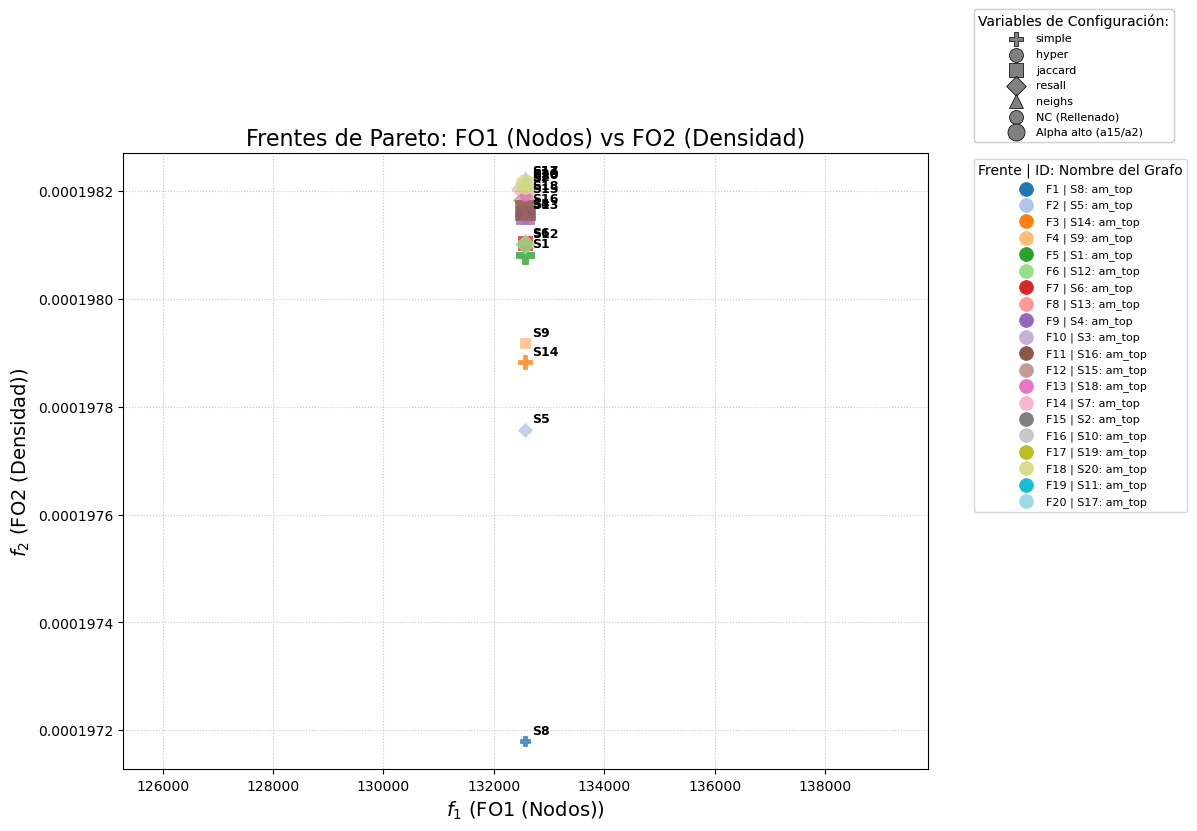


--- EVALUANDO: FO1 (Nodos) vs FO3 (CC) ---
Soluciones factibles encontradas: 20


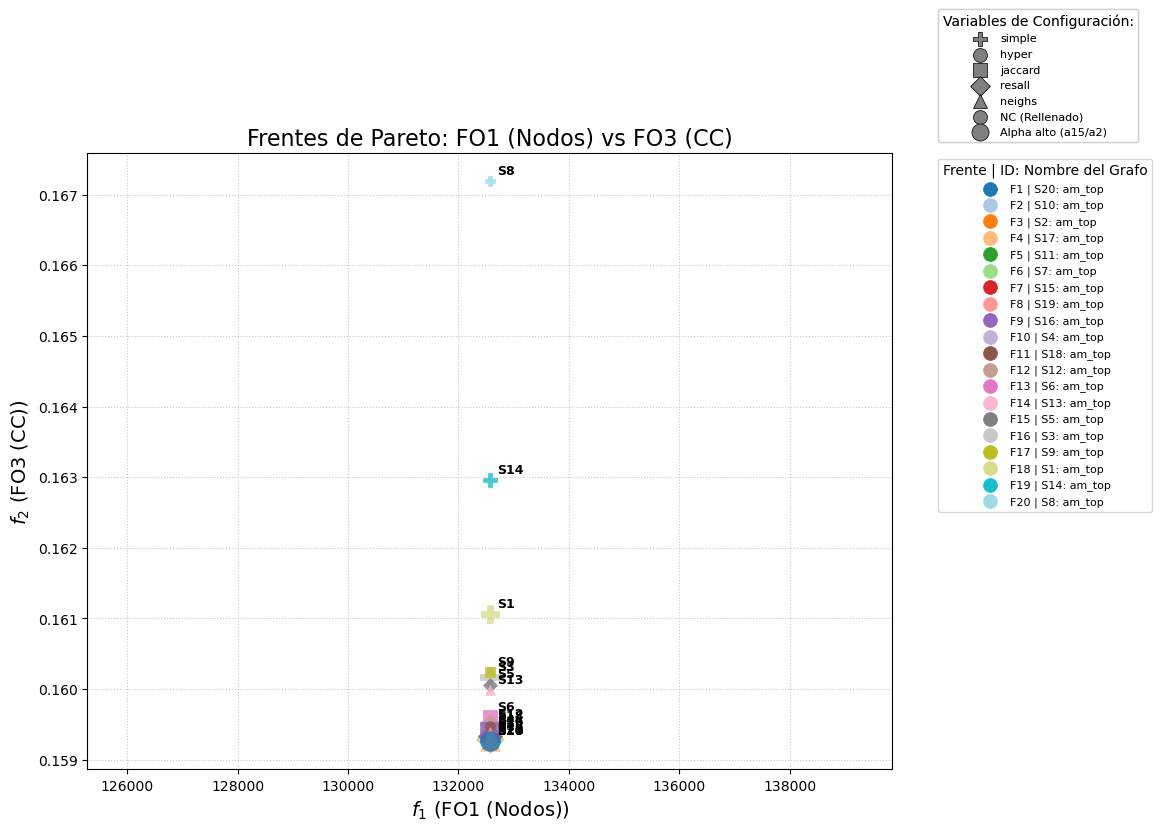


--- EVALUANDO: FO1 (Nodos) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 20


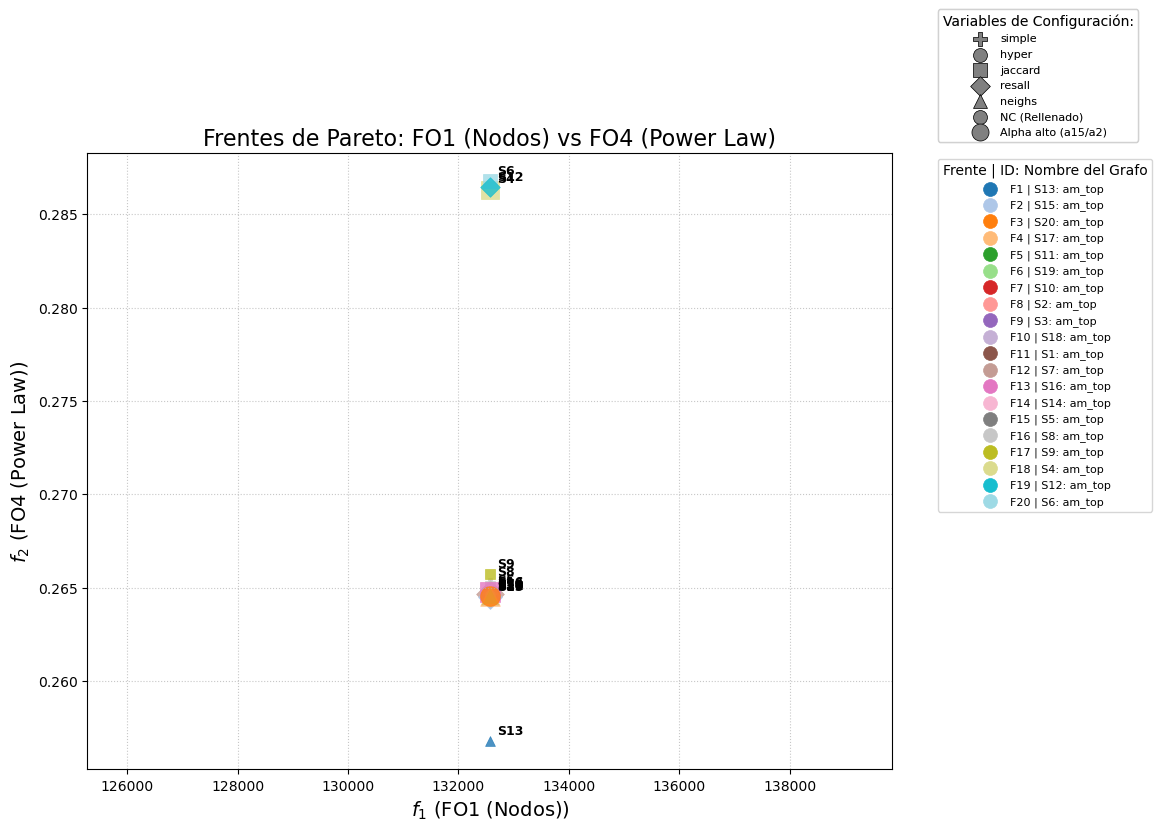


--- EVALUANDO: FO1 (Nodos) vs FO5 (APL) ---
Soluciones factibles encontradas: 20


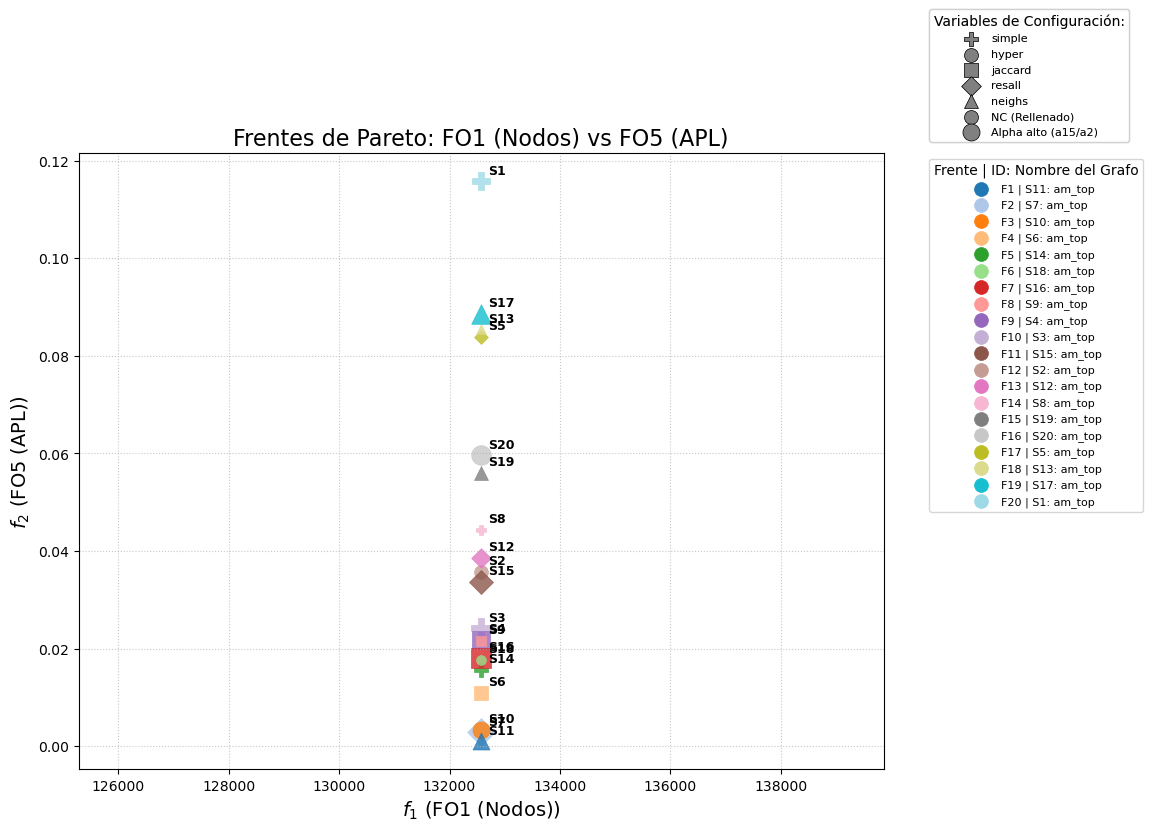


--- EVALUANDO: FO1 (Nodos) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 20


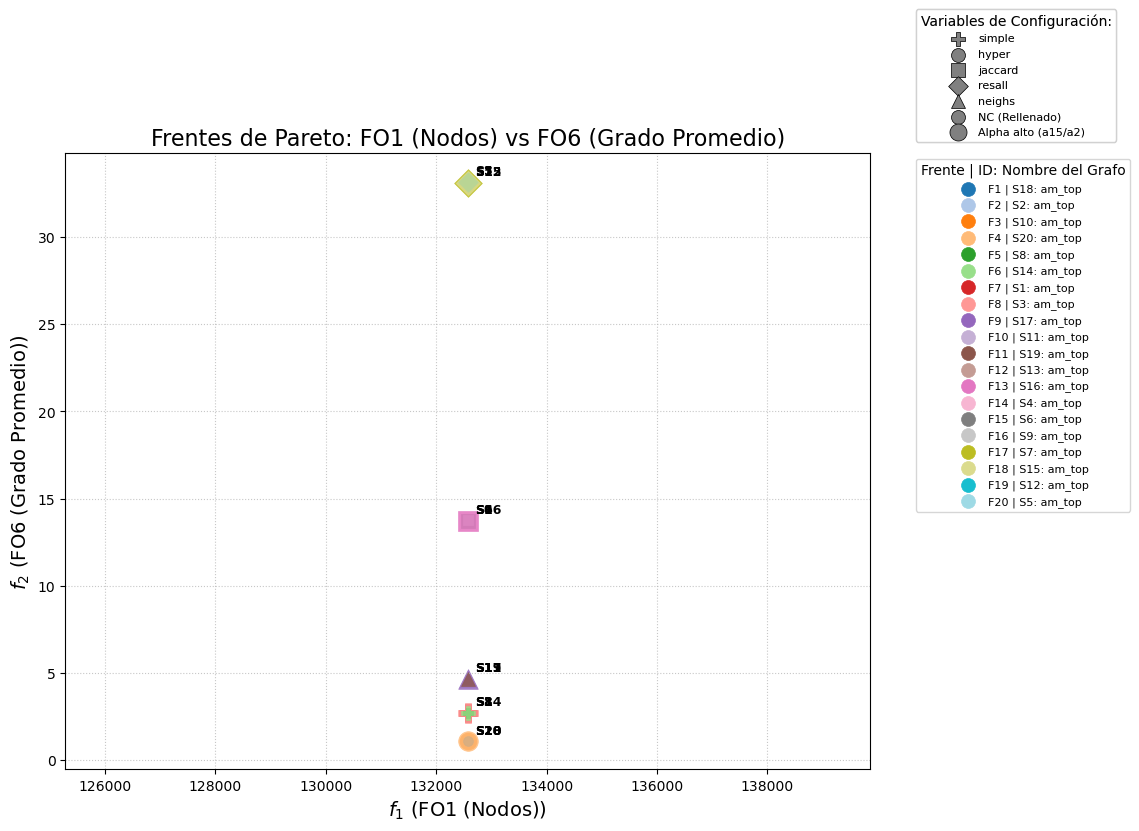


--- EVALUANDO: FO2 (Densidad) vs FO3 (CC) ---
Soluciones factibles encontradas: 20


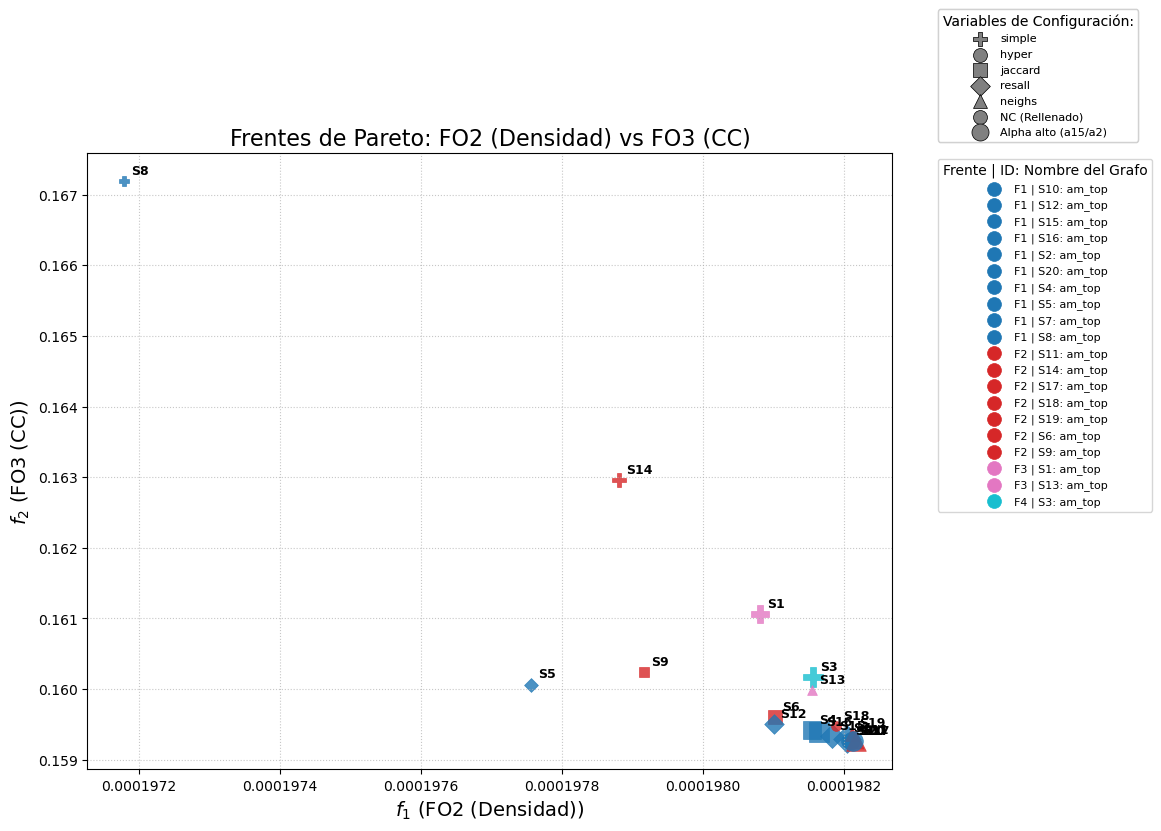


--- EVALUANDO: FO2 (Densidad) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 20


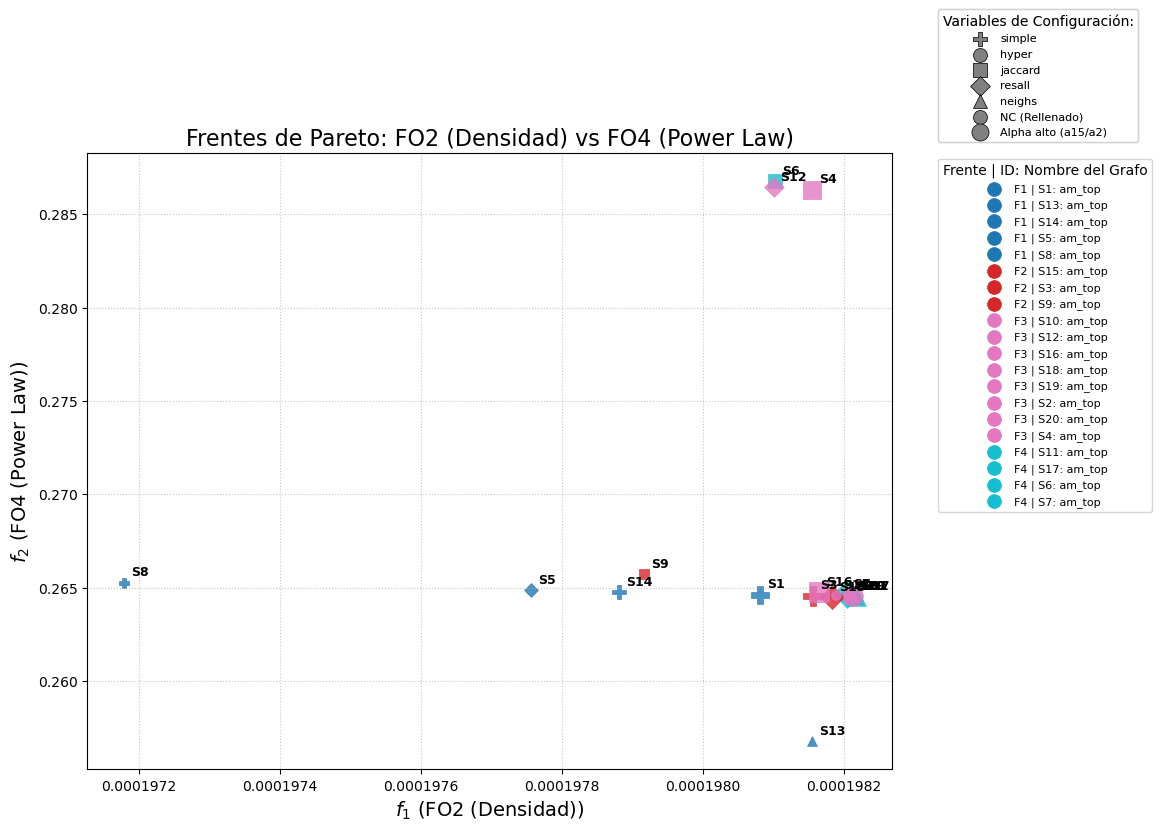


--- EVALUANDO: FO2 (Densidad) vs FO5 (APL) ---
Soluciones factibles encontradas: 20


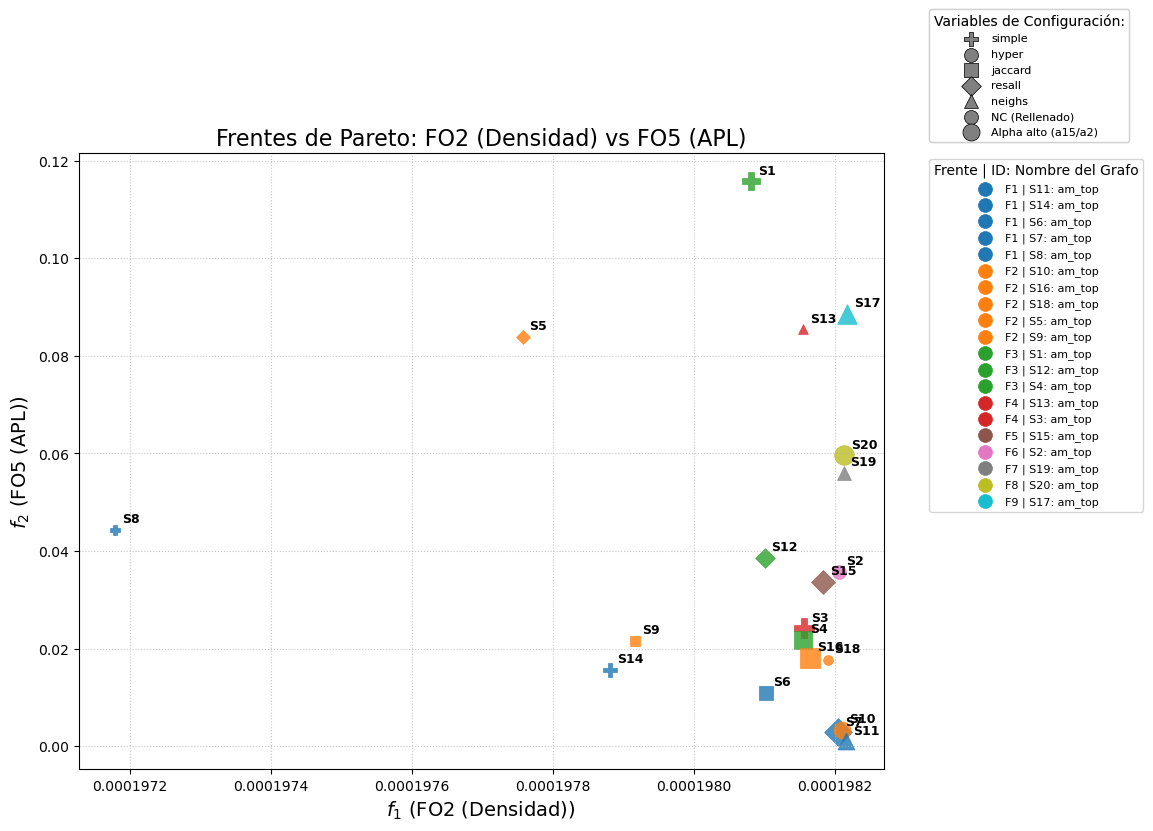


--- EVALUANDO: FO2 (Densidad) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 20


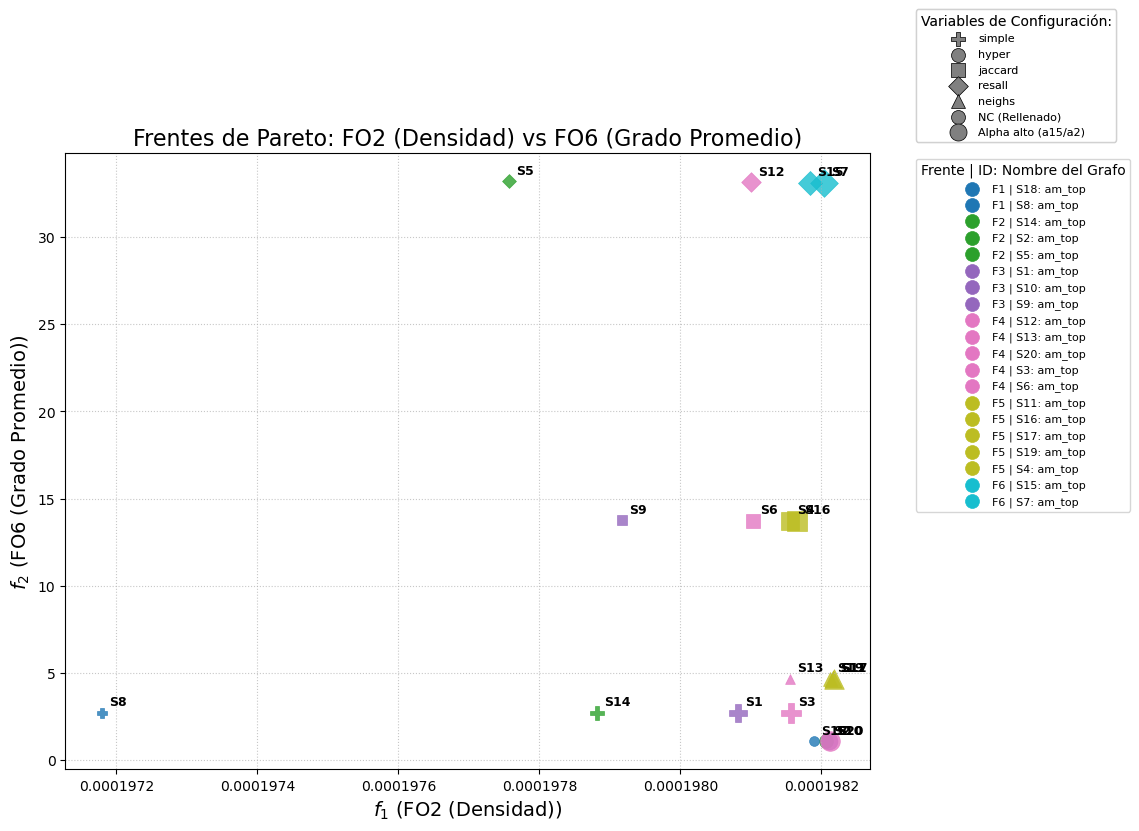


--- EVALUANDO: FO3 (CC) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 20


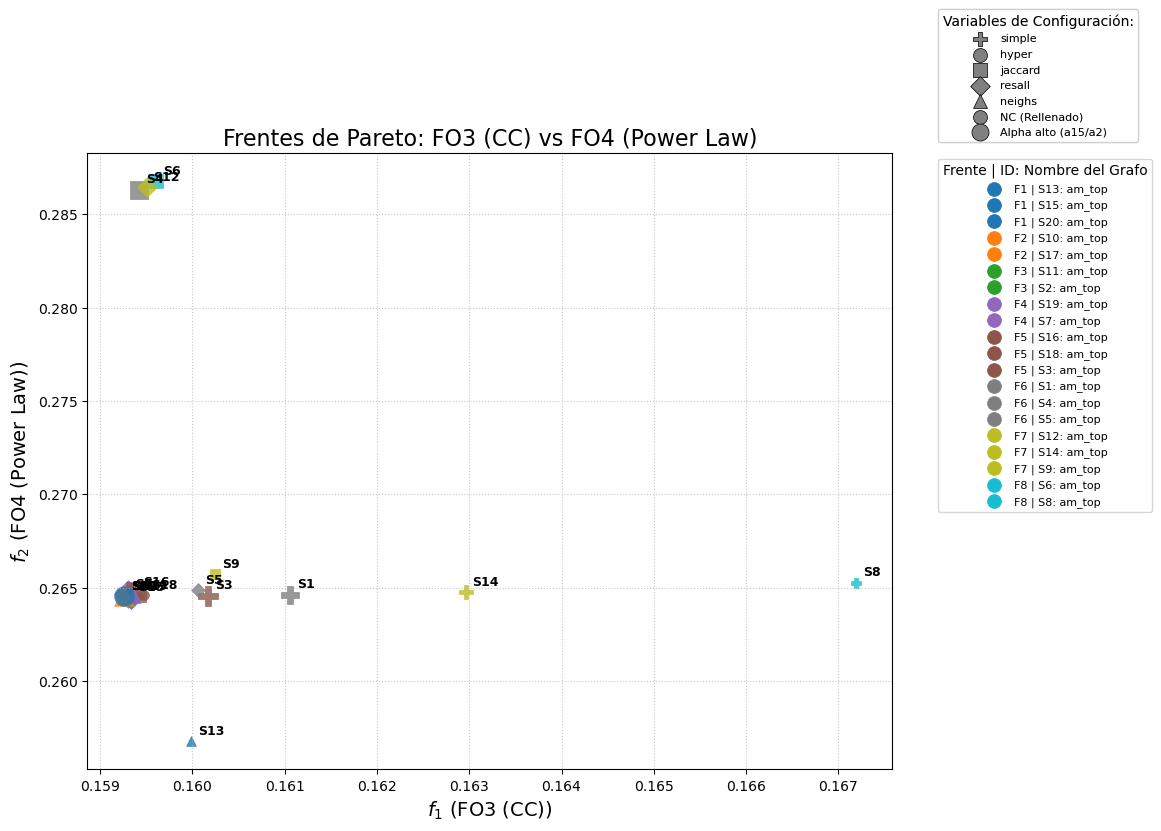


--- EVALUANDO: FO3 (CC) vs FO5 (APL) ---
Soluciones factibles encontradas: 20


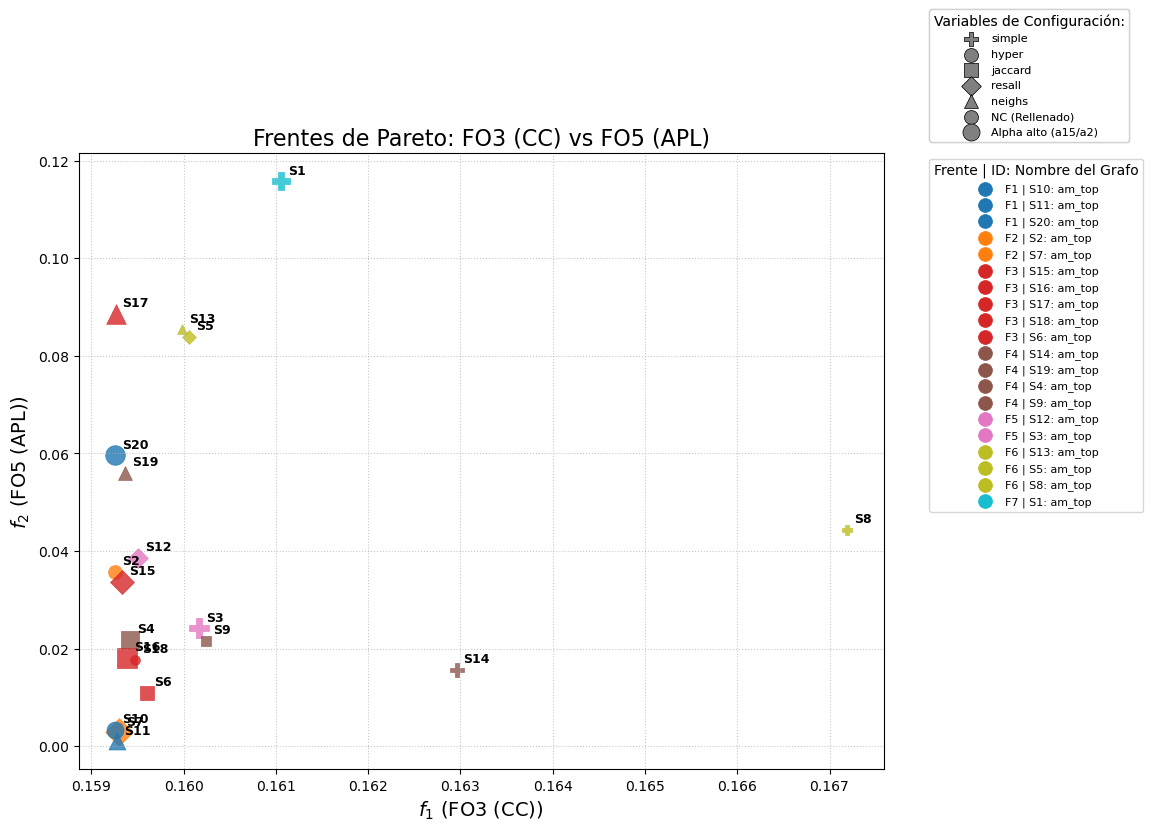


--- EVALUANDO: FO3 (CC) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 20


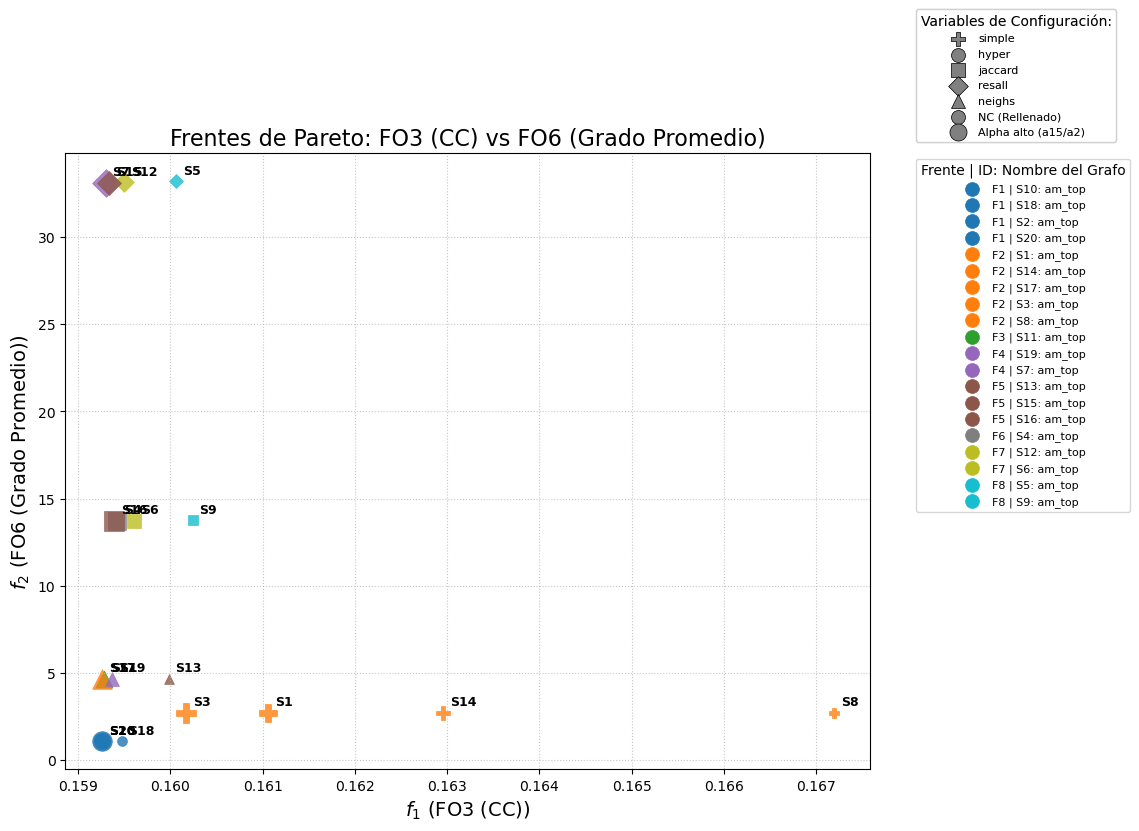


--- EVALUANDO: FO4 (Power Law) vs FO5 (APL) ---
Soluciones factibles encontradas: 20


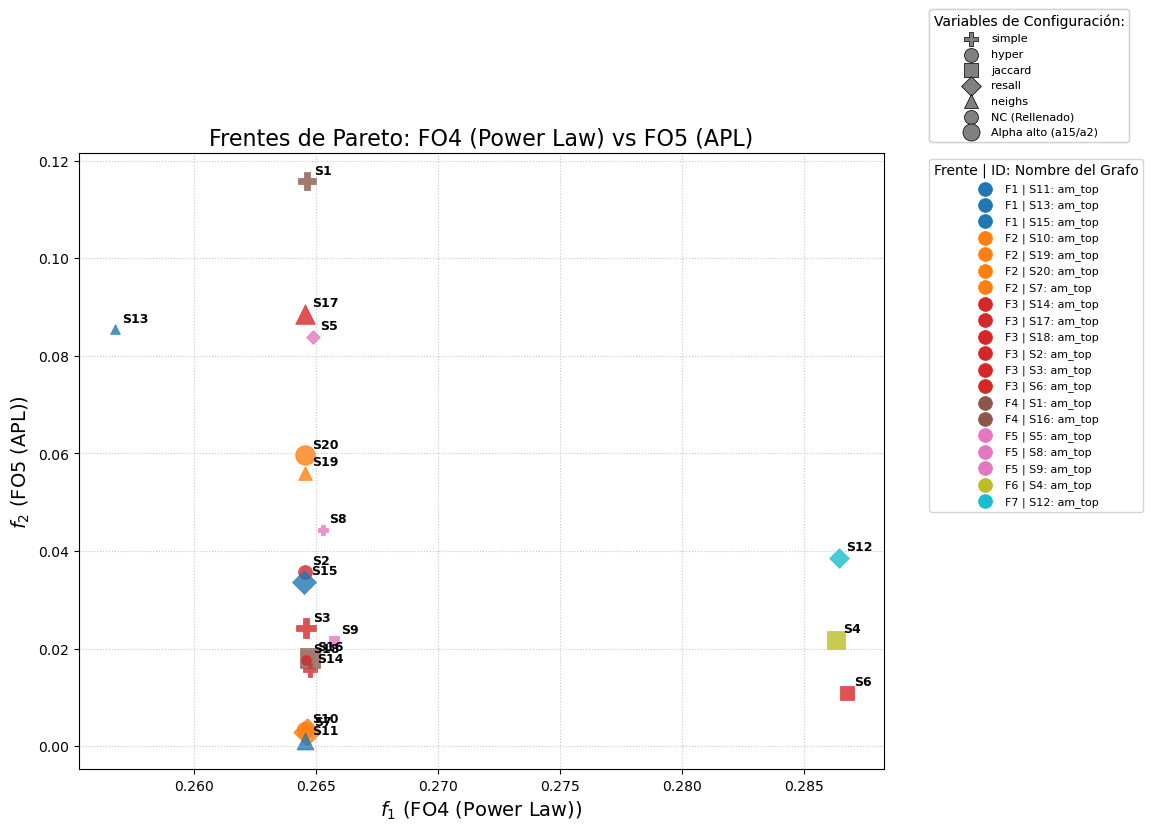


--- EVALUANDO: FO4 (Power Law) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 20


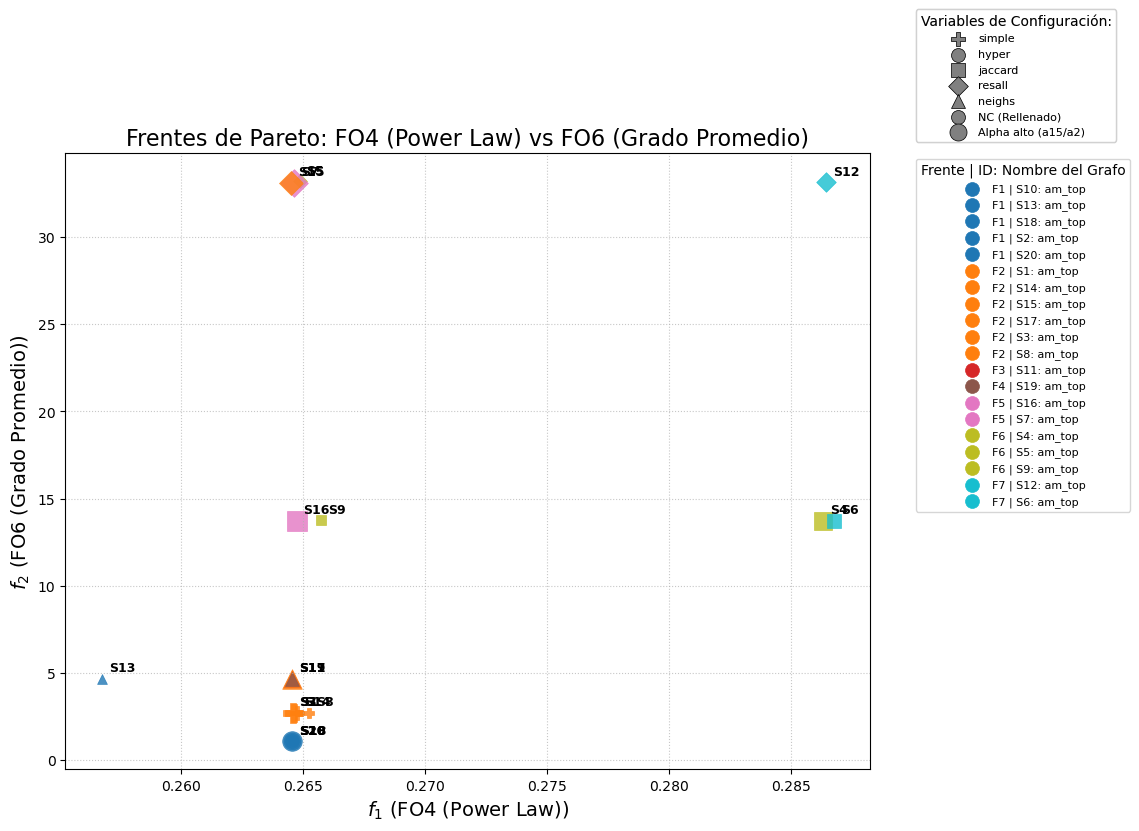


--- EVALUANDO: FO5 (APL) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 20


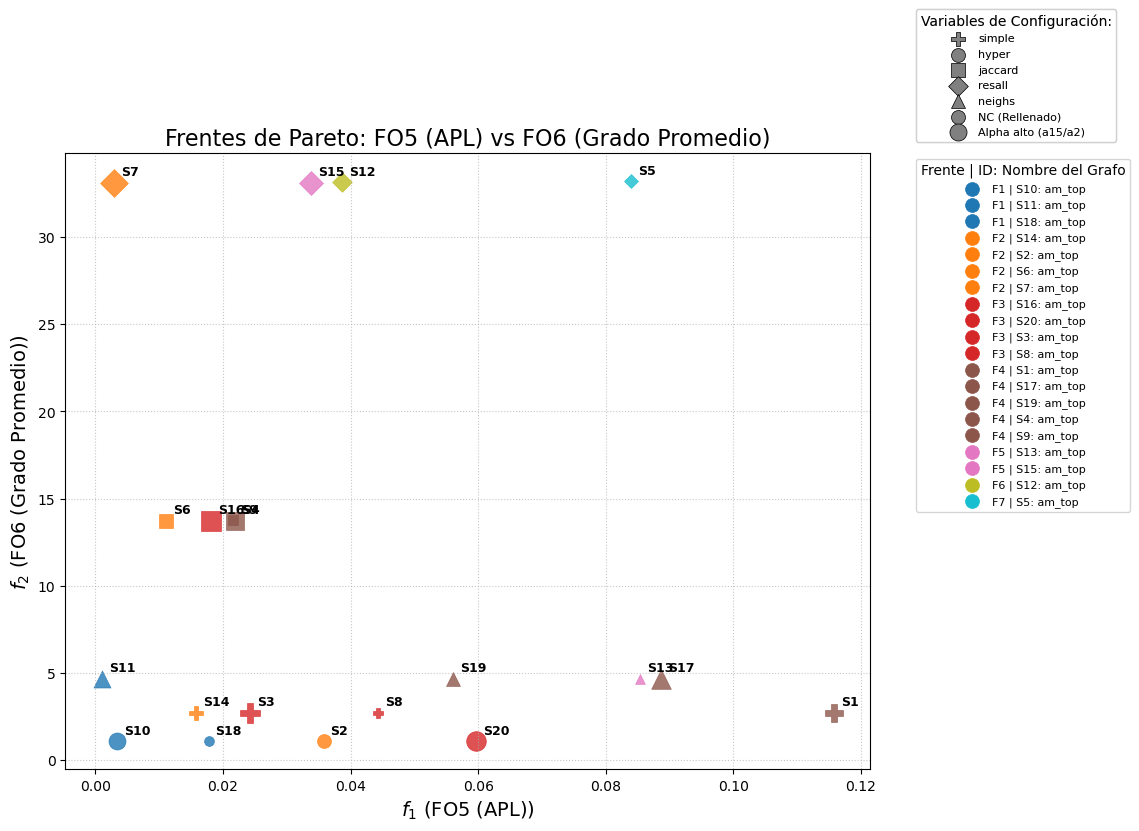

In [11]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]
# Definir los índices de las 6 FOs: [0, 1, 2, 3, 4, 5]
# FO1 = 0, FO2 = 1, FO3 = 2, FO4 = 3, FO5 = 4, FO6 = 5

# Definir los índices de las 6 FOs: [0, 1, 2, 3, 4, 5]
FO_INDICES = list(range(6)) 

# Generar TODAS las combinaciones únicas de pares (15 pares)
# Produce: (0, 1), (0, 2), ..., (0, 5), (1, 2), ..., (4, 5)
METRIC_PAIRS = list(itertools.combinations(FO_INDICES, 2))

# Nombres de las 6 FOs
FO_NAMES = ['FO1 (Nodos)', 'FO2 (Densidad)', 'FO3 (CC)', 'FO4 (Power Law)', 'FO5 (APL)', 'FO6 (Grado Promedio)']


# Bucle principal sobre las combinaciones
for metric_pair in METRIC_PAIRS:
    
    f_index1, f_index2 = metric_pair
    f_name1, f_name2 = FO_NAMES[f_index1], FO_NAMES[f_index2]
    
    print(f"\n--- EVALUANDO: {f_name1} vs {f_name2} ---")
    
    solutions = []
    to_df = []
    names_df = []
    
    # Bucle sobre los archivos de métricas (cargado desde tu script)
    for fname in metrics_files:
        cache_path = os.path.join(metrics_cache_dir, fname)

        # Cargar las métricas ya calculadas (asumimos bip_metrics está disponible)
        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)

        base_name = fname.replace("_metrics.pkl", "")

        # LLAMADA CLAVE: Se usa la versión corregida de evaluate_solution (Opción 1 de la respuesta anterior)
        # Asegúrate de que evaluate_solution esté definida para manejar las 6 métricas
        sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE, metric_pair)
        
        # Guardar valores de f y nombre
        to_df.append(sol["f"])
        names_df.append(base_name)
        sol["filename"] = base_name

        if is_feasible(sol):
            solutions.append(sol)

    # Crear dataset final para el par de métricas actual
    a = pd.DataFrame(to_df, columns=['f1', 'f2'])
    b = pd.DataFrame(names_df, columns=["name"])
    final_DF = pd.concat([a, b], axis=1)

    print(f"Soluciones factibles encontradas: {len(solutions)}")
    
    # -------------------------------------------------------------------------
    # Ejecutar Pareto Ranking y Plotting para el par de métricas actual
    # -------------------------------------------------------------------------

    all_fronts = pareto_rank_all(solutions)
    
    # Generar el título de la gráfica para este par de métricas
    plot_title = f"Frentes de Pareto: {f_name1} vs {f_name2}"
    
    # Llamamos a la lógica de plotting (que está en tu función plot_pareto_front)
    plot_pareto_front(final_DF, all_fronts, f_name1, f_name2, plot_title)

In [ ]:


NODETYPE = 1   # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 511463,
 'x2': 127823,
 'x3': 511463,
 'x8': 0.3253,
 'x9': 3.2322,
 'x11': 5.0662,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 511463,
 'x2': 127823,
 'x3': 511463,
 'x8': 0.3253,
 'x9': 3.2322,
 'x11': 5.0662,
 'x15': 1.1241883410574385e-05,
 'x16': 11.503438348341065}


--- EVALUANDO: FO1 (Nodos) vs FO2 (Densidad) ---
Soluciones factibles encontradas: 26


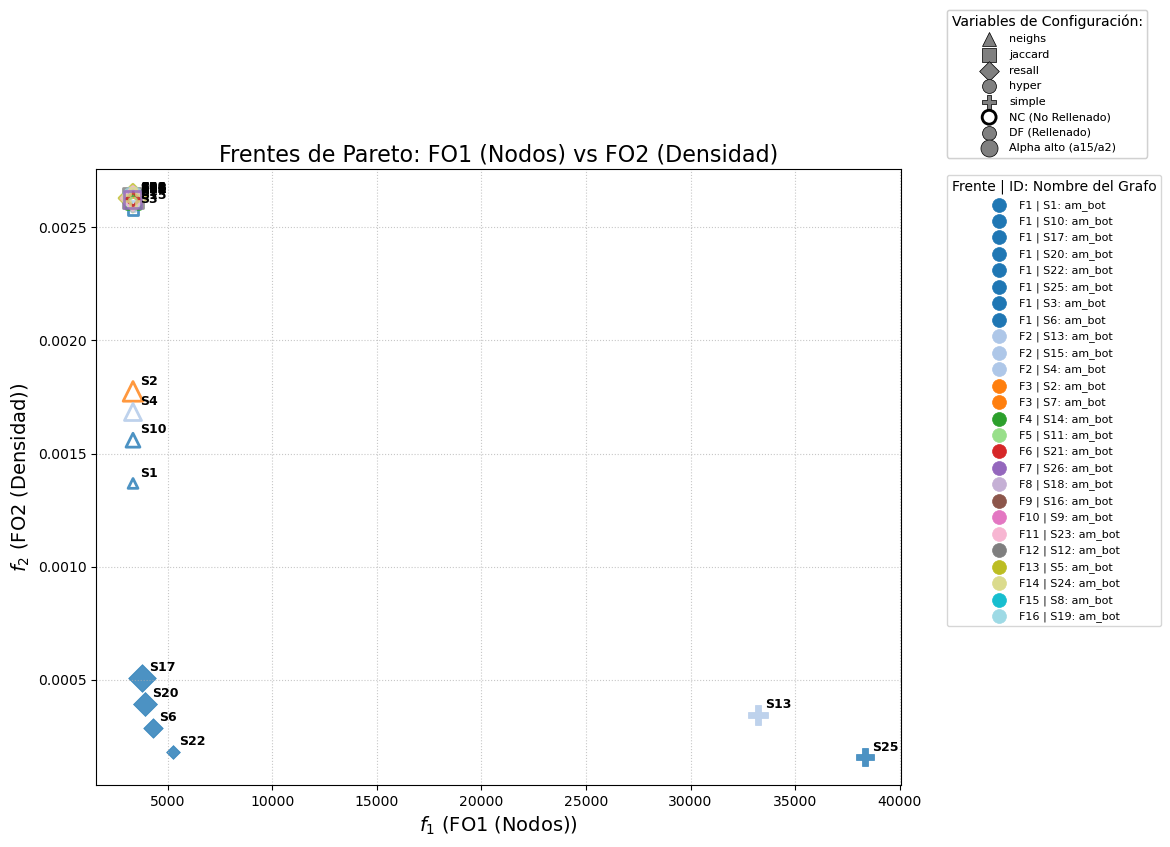


--- EVALUANDO: FO1 (Nodos) vs FO3 (CC) ---
Soluciones factibles encontradas: 26


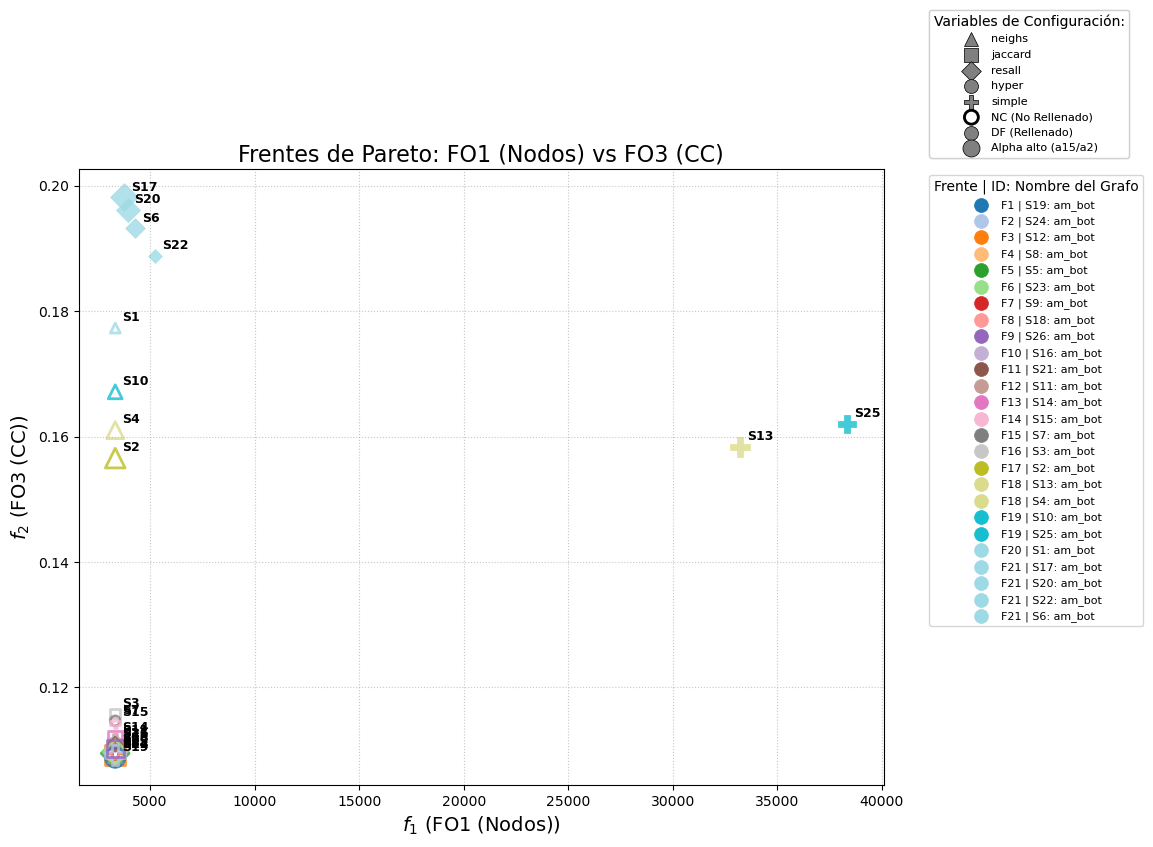


--- EVALUANDO: FO1 (Nodos) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 26


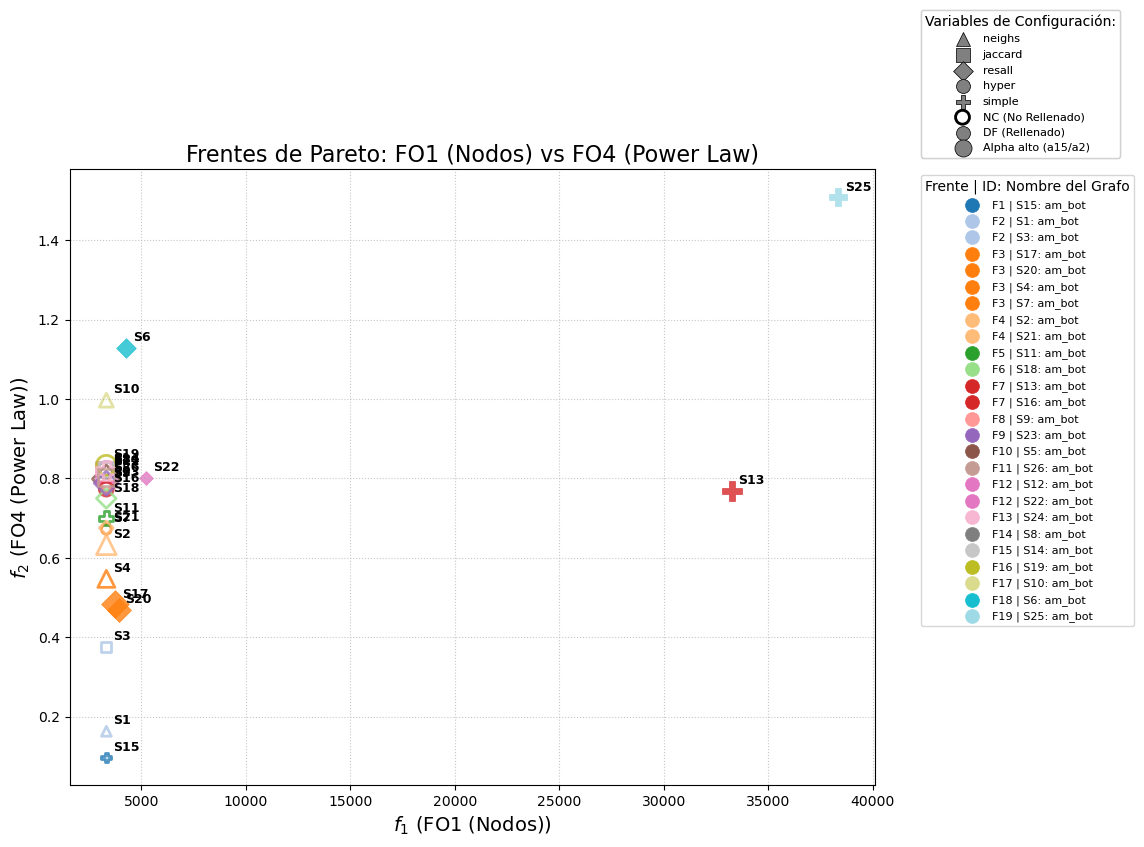


--- EVALUANDO: FO1 (Nodos) vs FO5 (APL) ---
Soluciones factibles encontradas: 26


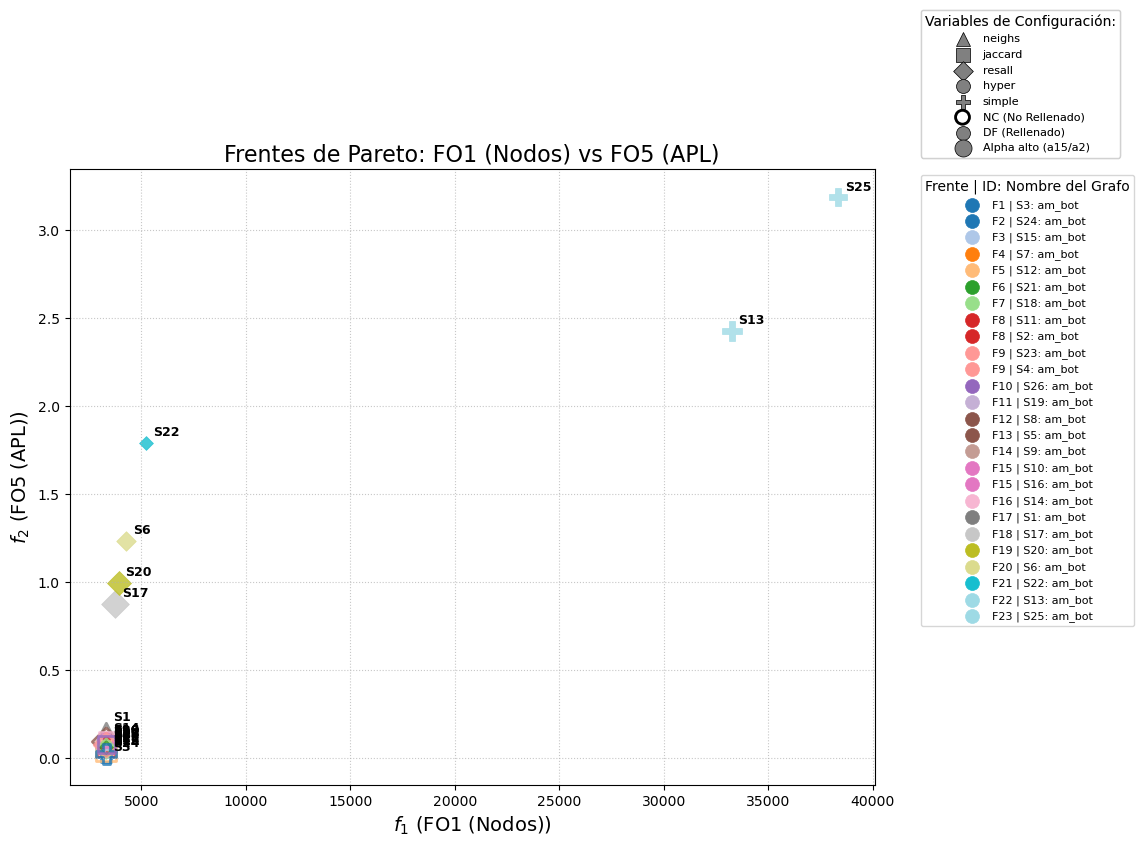


--- EVALUANDO: FO1 (Nodos) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 26


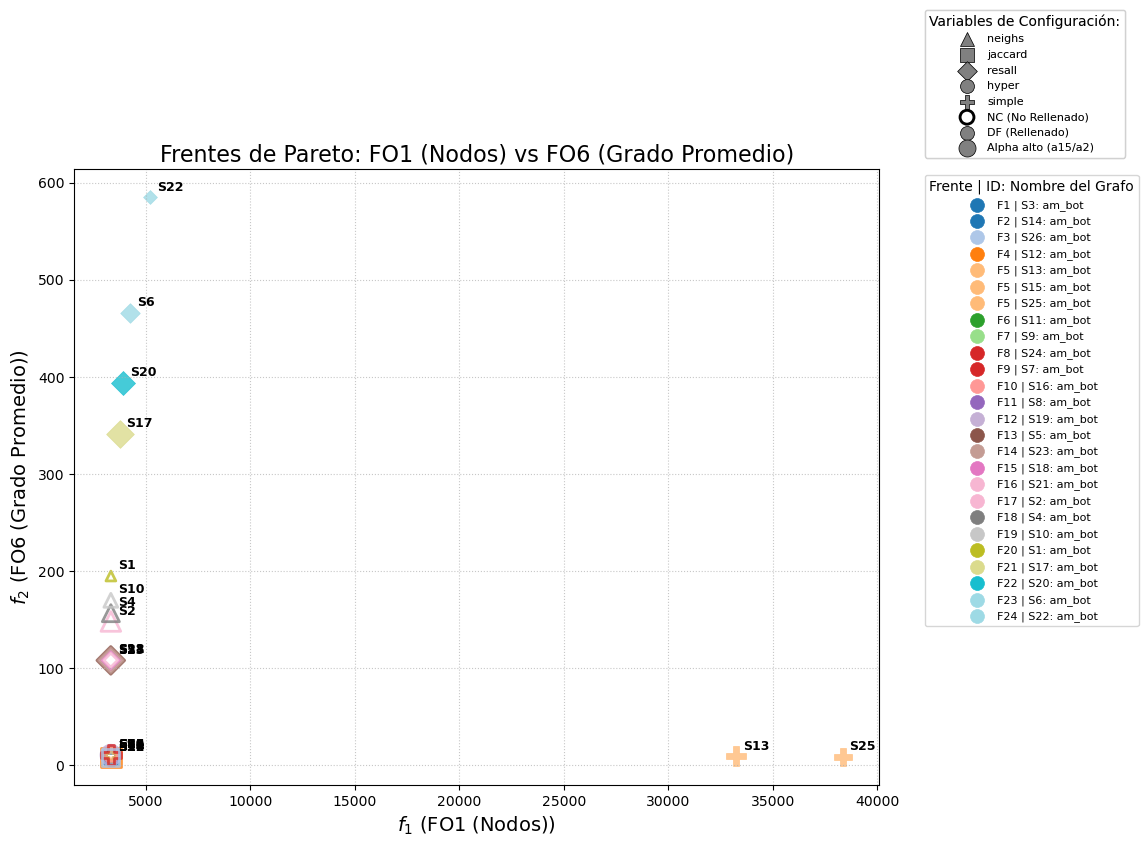


--- EVALUANDO: FO2 (Densidad) vs FO3 (CC) ---
Soluciones factibles encontradas: 26


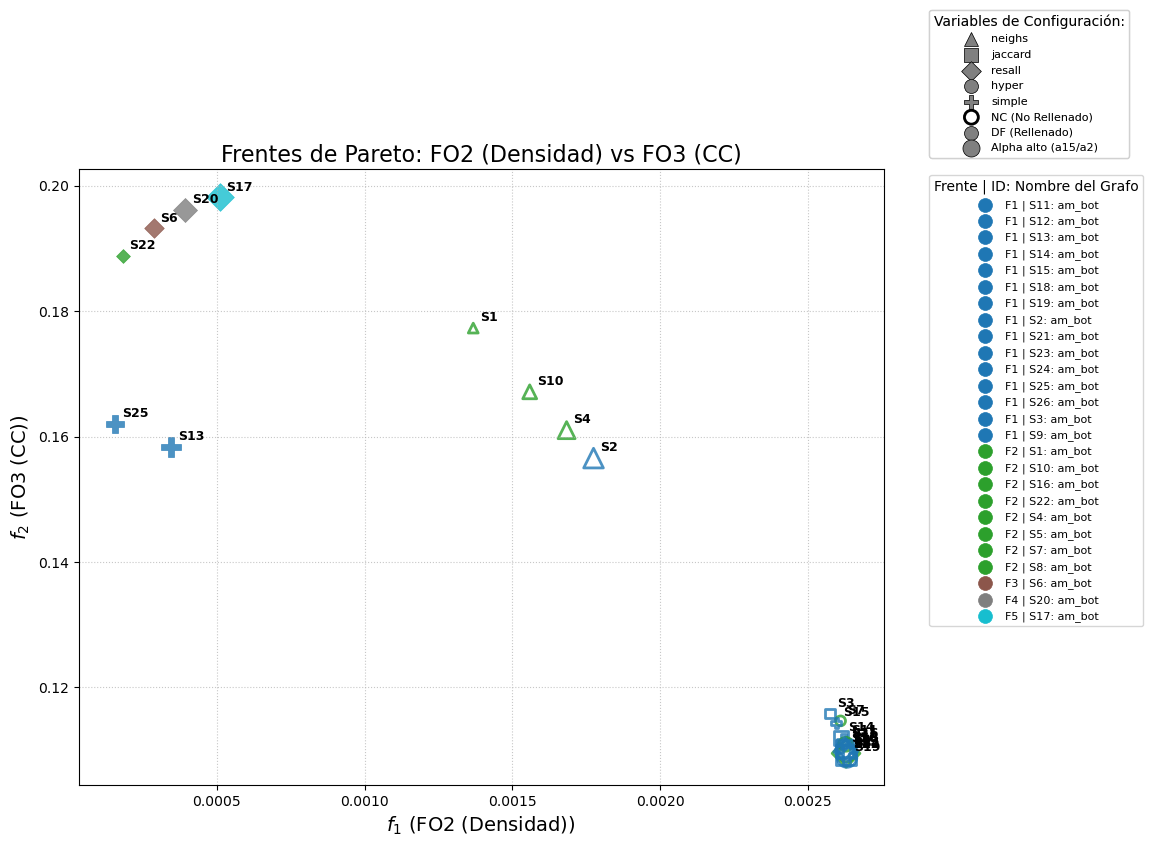


--- EVALUANDO: FO2 (Densidad) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 26


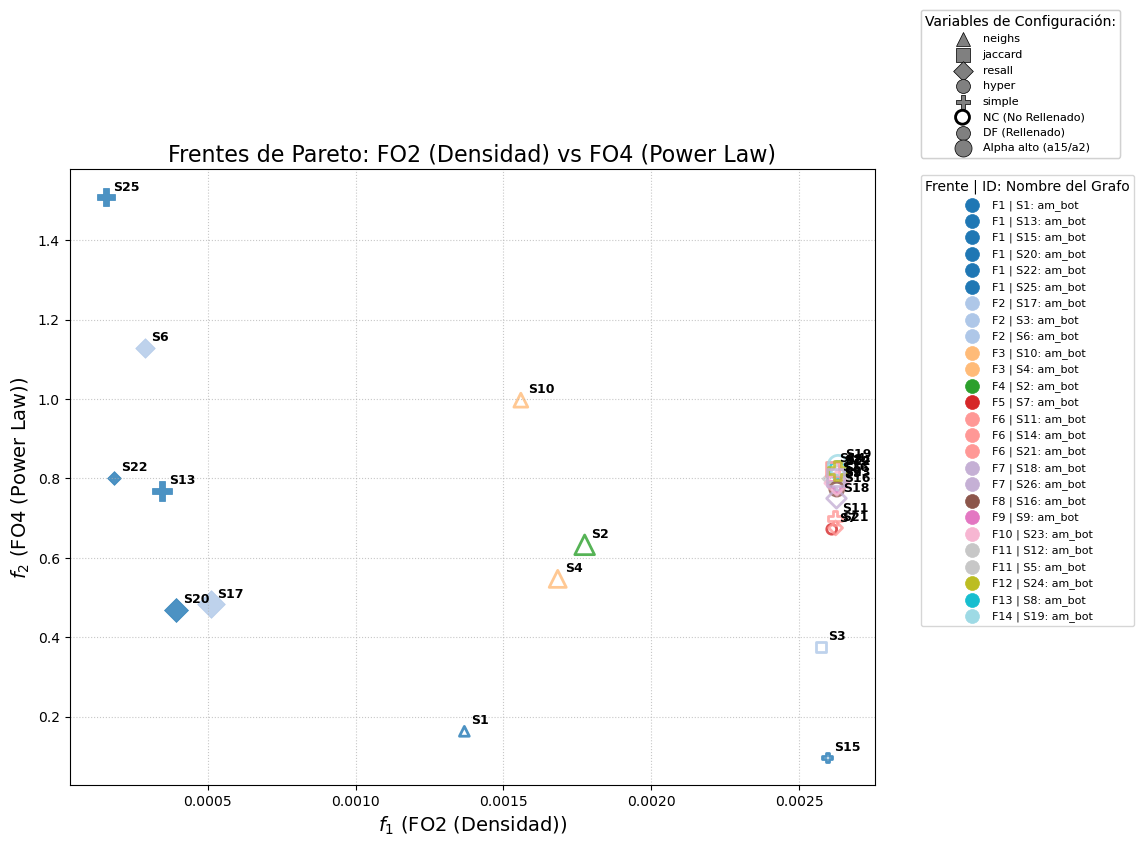


--- EVALUANDO: FO2 (Densidad) vs FO5 (APL) ---
Soluciones factibles encontradas: 26


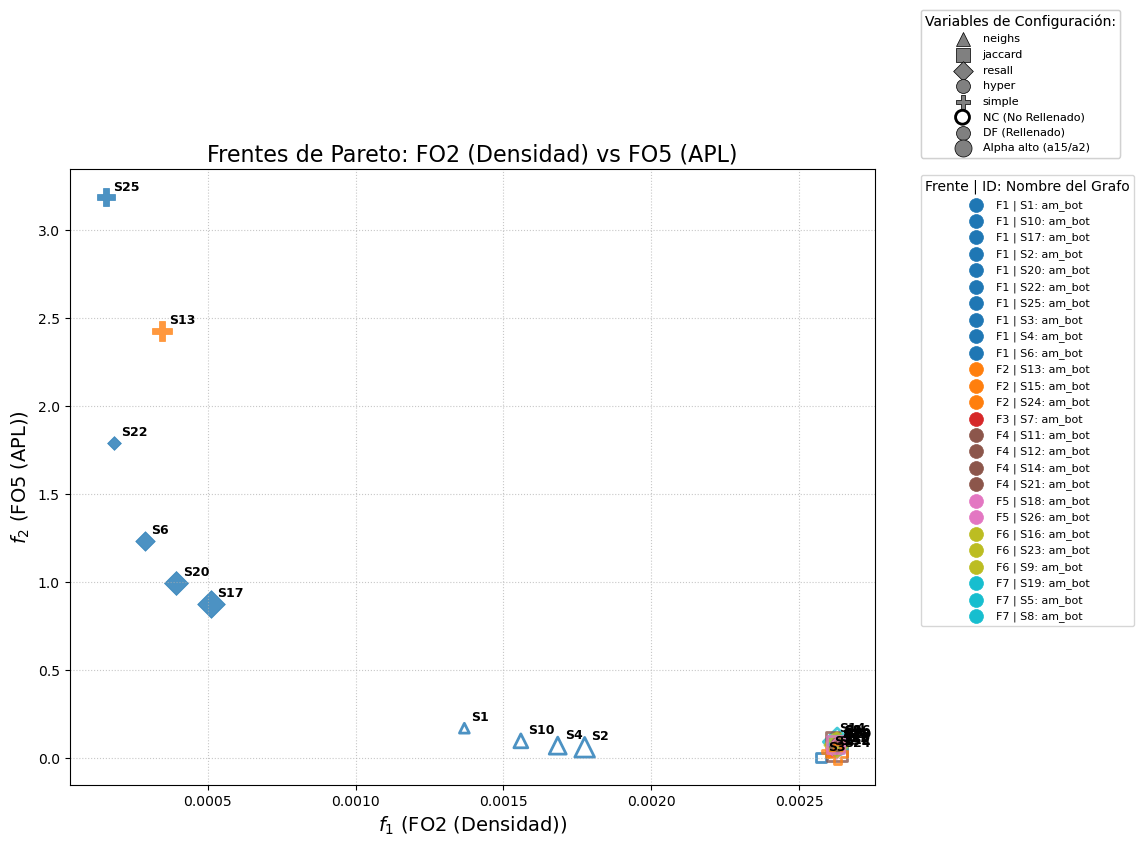


--- EVALUANDO: FO2 (Densidad) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 26


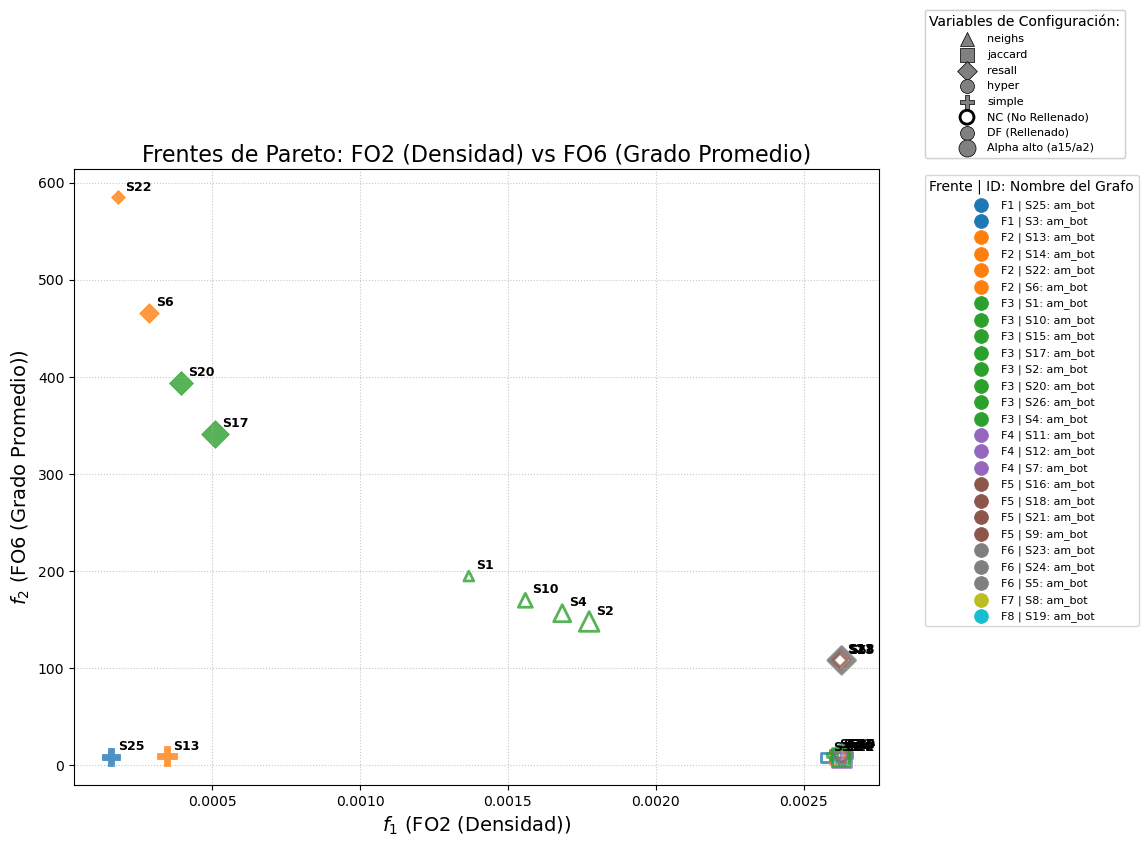


--- EVALUANDO: FO3 (CC) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 26


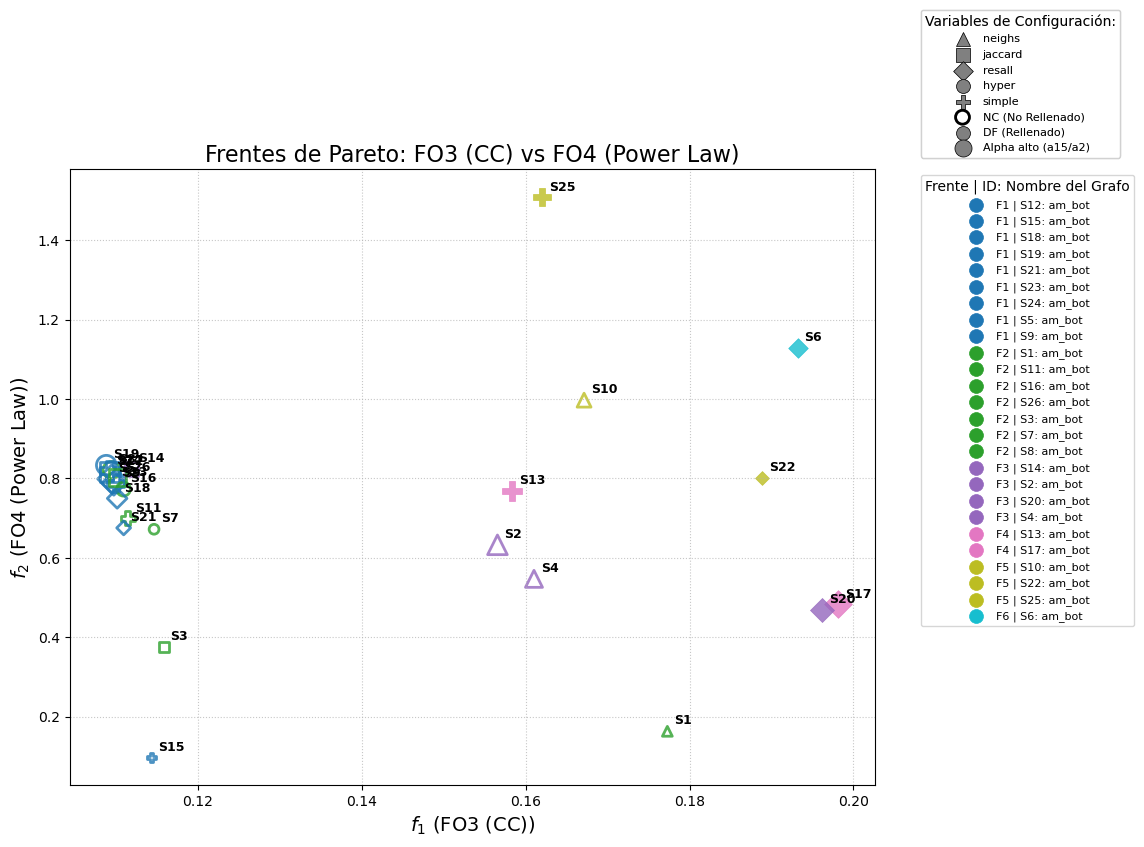


--- EVALUANDO: FO3 (CC) vs FO5 (APL) ---
Soluciones factibles encontradas: 26


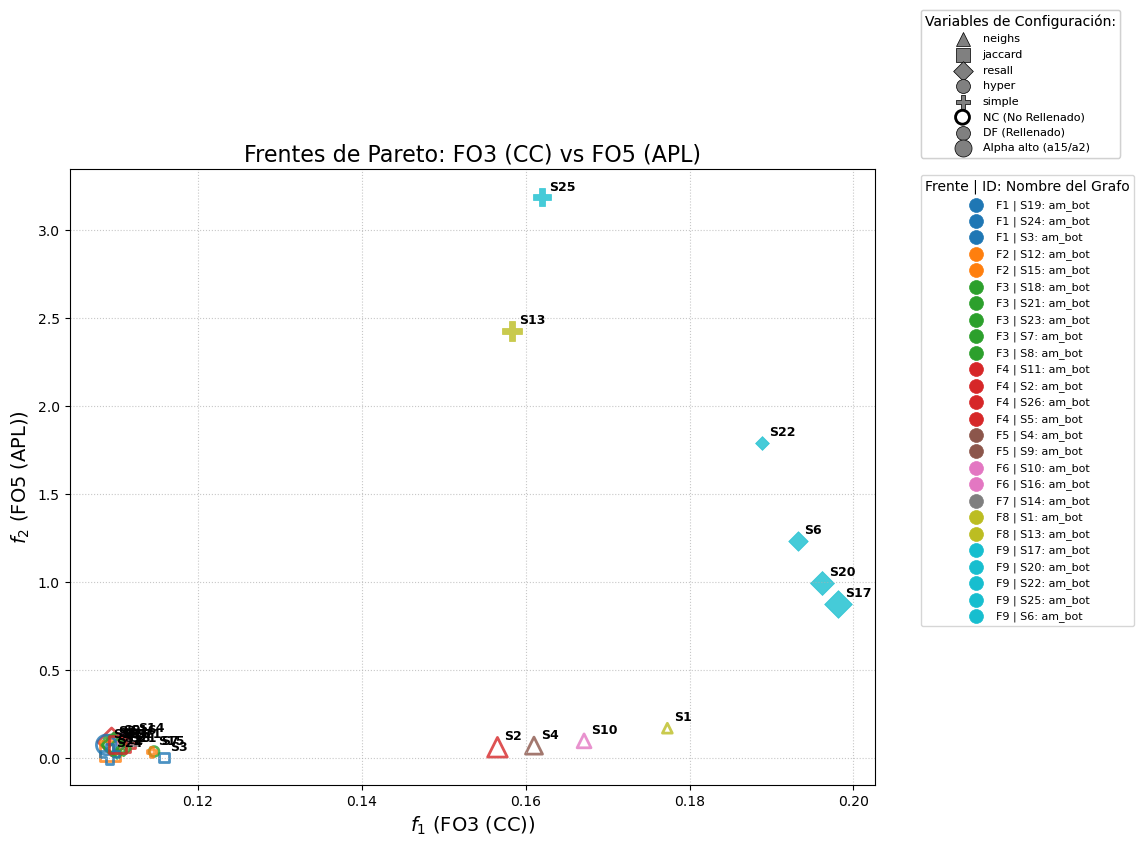


--- EVALUANDO: FO3 (CC) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 26


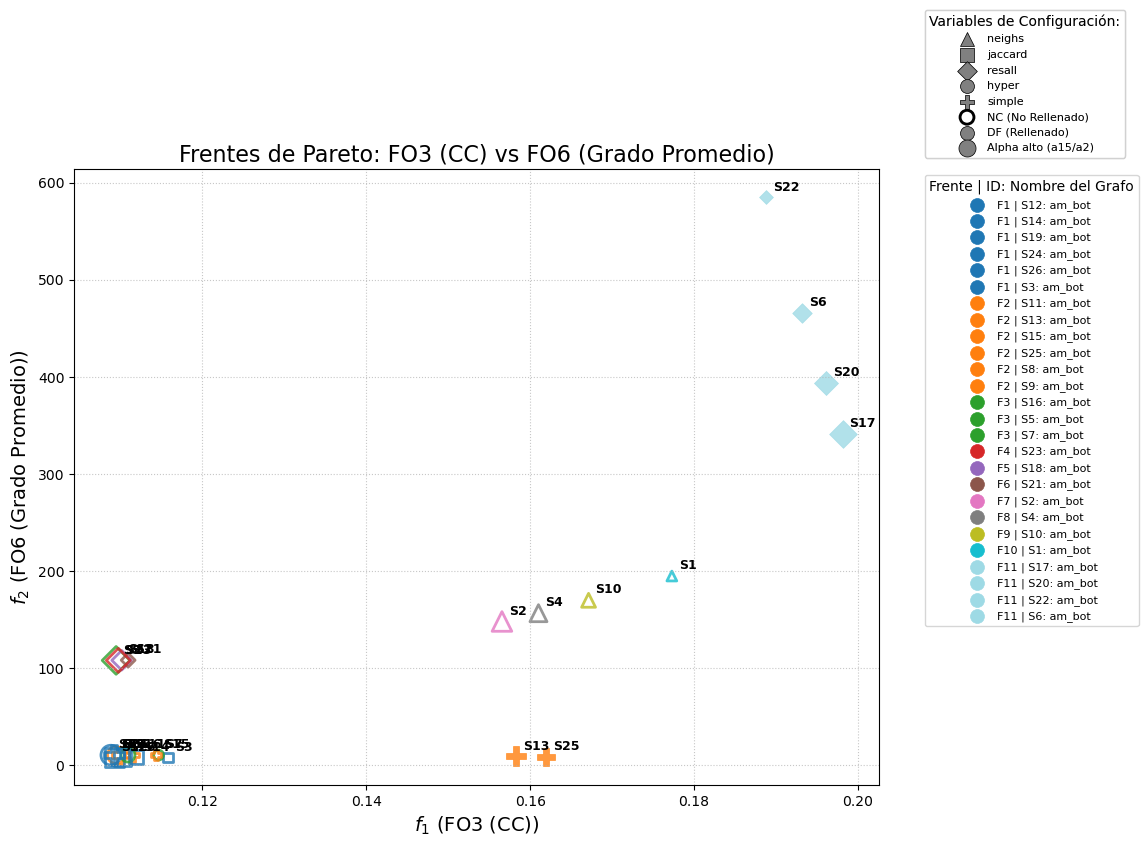


--- EVALUANDO: FO4 (Power Law) vs FO5 (APL) ---
Soluciones factibles encontradas: 26


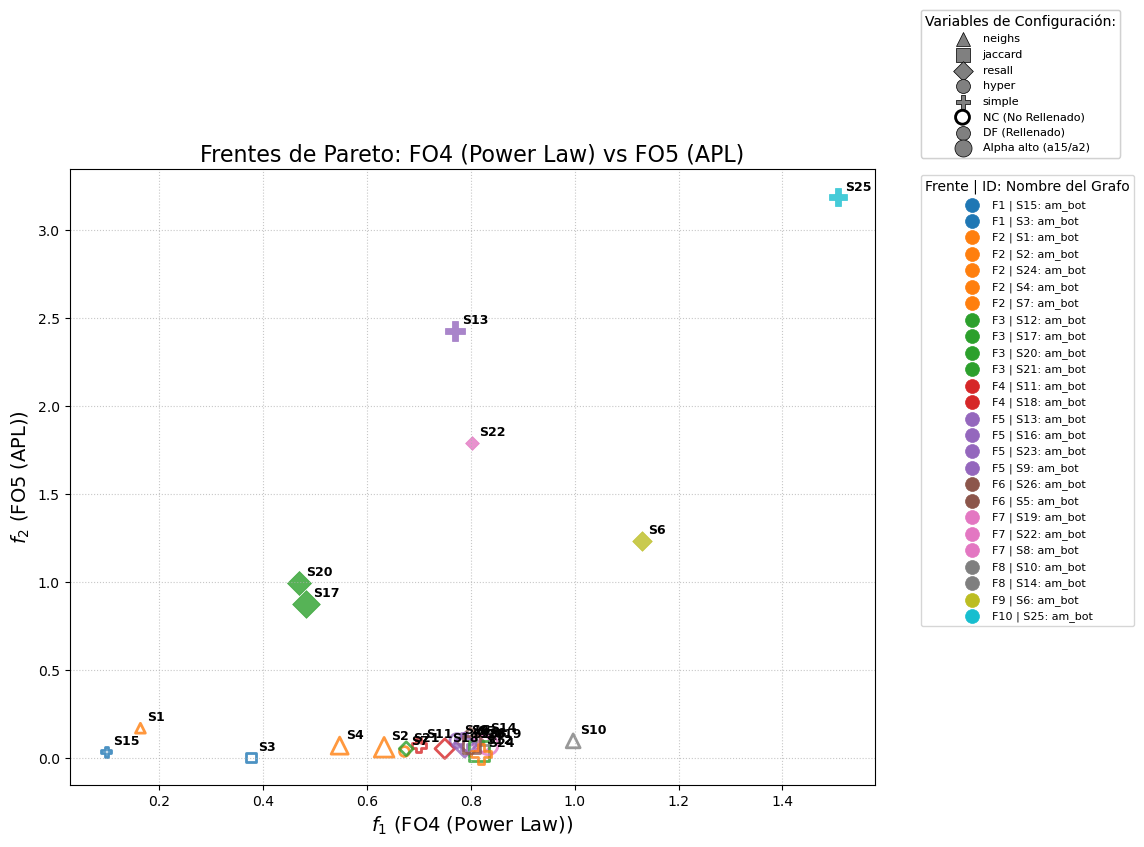


--- EVALUANDO: FO4 (Power Law) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 26


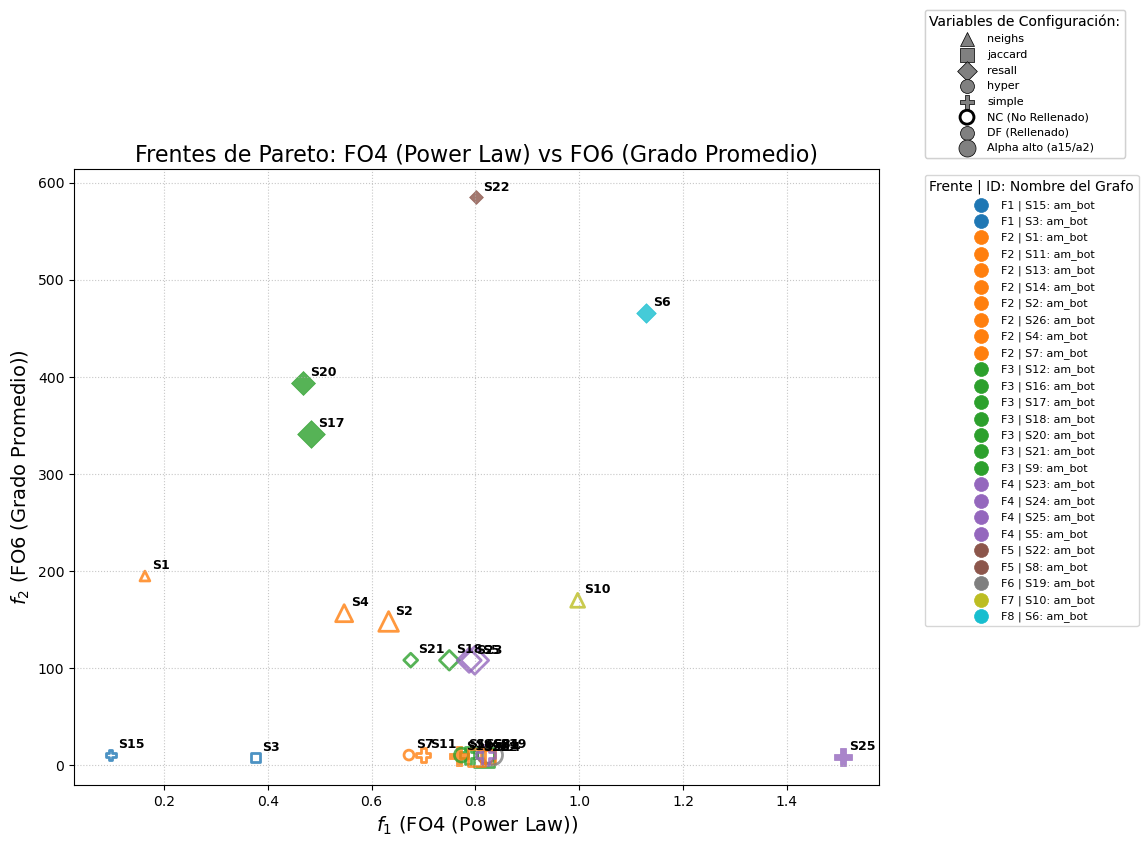


--- EVALUANDO: FO5 (APL) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 26


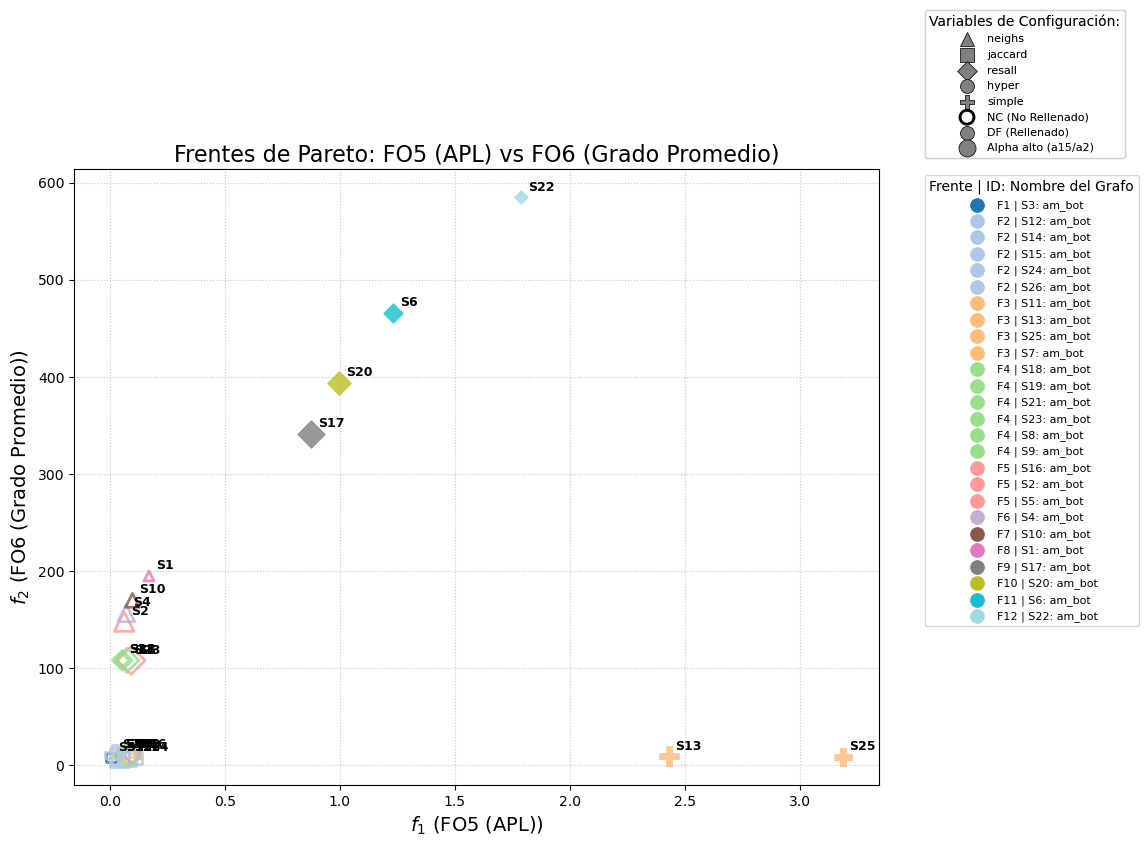

In [13]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]
# Definir los índices de las 6 FOs: [0, 1, 2, 3, 4, 5]
# FO1 = 0, FO2 = 1, FO3 = 2, FO4 = 3, FO5 = 4, FO6 = 5

# Definir los índices de las 6 FOs: [0, 1, 2, 3, 4, 5]
FO_INDICES = list(range(6)) 

# Generar TODAS las combinaciones únicas de pares (15 pares)
# Produce: (0, 1), (0, 2), ..., (0, 5), (1, 2), ..., (4, 5)
METRIC_PAIRS = list(itertools.combinations(FO_INDICES, 2))

# Nombres de las 6 FOs
FO_NAMES = ['FO1 (Nodos)', 'FO2 (Densidad)', 'FO3 (CC)', 'FO4 (Power Law)', 'FO5 (APL)', 'FO6 (Grado Promedio)']


# Bucle principal sobre las combinaciones
for metric_pair in METRIC_PAIRS:
    
    f_index1, f_index2 = metric_pair
    f_name1, f_name2 = FO_NAMES[f_index1], FO_NAMES[f_index2]
    
    print(f"\n--- EVALUANDO: {f_name1} vs {f_name2} ---")
    
    solutions = []
    to_df = []
    names_df = []
    
    # Bucle sobre los archivos de métricas (cargado desde tu script)
    for fname in metrics_files:
        cache_path = os.path.join(metrics_cache_dir, fname)

        # Cargar las métricas ya calculadas (asumimos bip_metrics está disponible)
        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)

        base_name = fname.replace("_metrics.pkl", "")

        # LLAMADA CLAVE: Se usa la versión corregida de evaluate_solution (Opción 1 de la respuesta anterior)
        # Asegúrate de que evaluate_solution esté definida para manejar las 6 métricas
        sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE, metric_pair)
        
        # Guardar valores de f y nombre
        to_df.append(sol["f"])
        names_df.append(base_name)
        sol["filename"] = base_name

        if is_feasible(sol):
            solutions.append(sol)

    # Crear dataset final para el par de métricas actual
    a = pd.DataFrame(to_df, columns=['f1', 'f2'])
    b = pd.DataFrame(names_df, columns=["name"])
    final_DF = pd.concat([a, b], axis=1)

    print(f"Soluciones factibles encontradas: {len(solutions)}")
    
    # -------------------------------------------------------------------------
    # Ejecutar Pareto Ranking y Plotting para el par de métricas actual
    # -------------------------------------------------------------------------

    all_fronts = pareto_rank_all(solutions)
    
    # Generar el título de la gráfica para este par de métricas
    plot_title = f"Frentes de Pareto: {f_name1} vs {f_name2}"
    
    # Llamamos a la lógica de plotting (que está en tu función plot_pareto_front)
    plot_pareto_front(final_DF, all_fronts, f_name1, f_name2, plot_title)